# **Preprocessing: From Raw Data to Guayas-Region Time Series**


_Filtering, Cleaning, and Preparing Retail Sales Data for Forecasting_


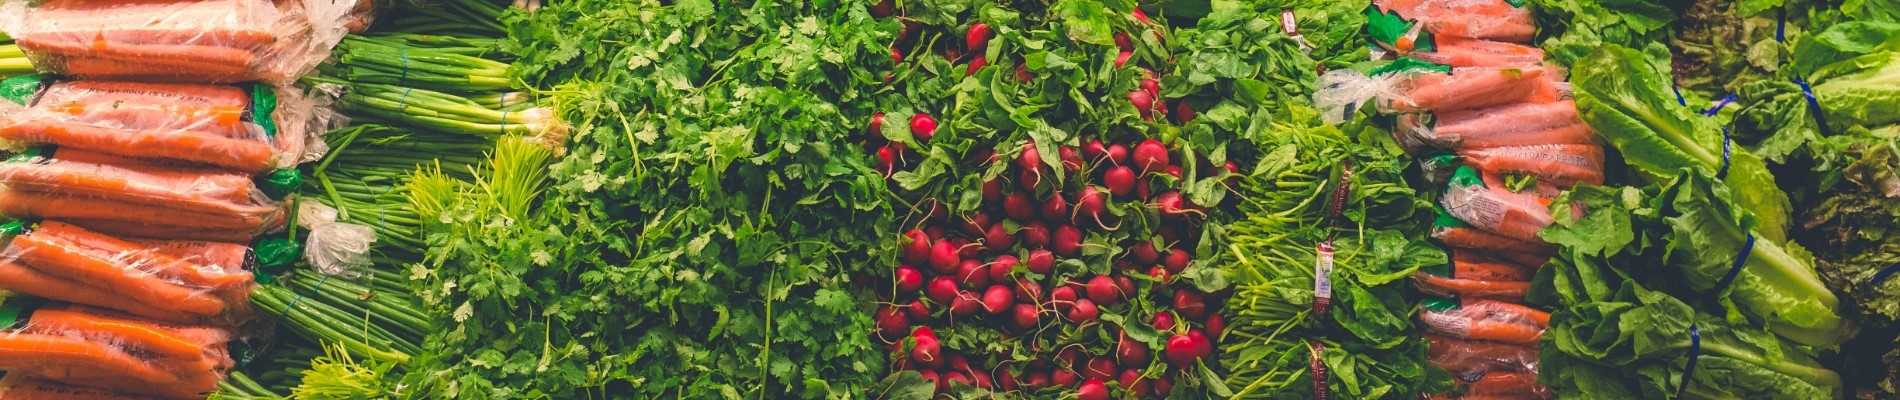


## **1️⃣ Notebook Description**


### **1.1 The Goal**


Corporación Favorita’s dataset is enormous—4.8 GB of daily sales across hundreds of stores and thousands of items. But effective forecasting doesn’t start with raw volume; it starts with **focused, clean, and continuous time series**. Before we can analyze trends or train any model, we must carefully shape the dataset into something meaningful, manageable, and statistically reliable.

This notebook performs that essential transformation. Specifically, we will:

- **Filter the dataset to the Guayas region**, our forecasting scope, using chunked loading to avoid memory overload.
- **Narrow the dataset to the top 3 item families** (by item count), ensuring we focus on the most representative and impactful product groups.
- **Inspect and treat missing values**, including gaps in promotions, oil prices, and holiday metadata.
- **Detect and handle outliers**, such as negative sales (returns), extreme spikes, and anomalies caused by events like the 2016 earthquake.
- **Fill missing dates** to create gap‑free daily timelines for every store–item pair, a requirement for rolling windows, lag features, and LSTM sequence modeling.
- **Save the cleaned, structured dataset** to:  
  `data/processed/cleaner/`
  <br>
  ready for EDA and model development.


### **1.2 Why It Matters**


Time‑series forecasting models are extremely sensitive to missing timestamps, irregular intervals, and noisy or irrelevant data. Working with the full nationwide dataset introduces unnecessary complexity and dilutes the patterns we want to learn. By focusing on **Guayas stores** and the **top 3 item families**, we reduce noise while preserving the core behavioral signals that matter.

This preprocessing step ensures that our dataset is:

- Region‑specific
- Product‑focused
- Clean and continuous
- Free of structural gaps and anomalies
- Ready for meaningful analysis and robust forecasting

In short, this notebook transforms a massive raw dataset into a precise, reliable foundation—so our forecasts reflect real consumer behavior rather than data inconsistencies.


## **2️⃣ Project Directory & Path Configuration**


We start by connecting this Colab session to Google Drive.  
This gives us a persistent, cloud‑based workspace where we can store data, notebooks, and model outputs across sessions.

Run the cell below **once per session** to grant Colab access to your Drive.


In [52]:
# Betriebssystem-Funktionen für Dateipfad-Operationen importieren
import os

# Pandas-Bibliothek für Datenanalyse und -manipulation importieren
import pandas as pd

# NumPy-Bibliothek für numerische Berechnungen und Array-Operationen importieren
import numpy as np

# System-spezifische Parameter und Funktionen importieren
import sys

# Moderne, objektorientierte Dateipfad-Bibliothek importieren
from pathlib import Path

# 1️⃣ Projekt-Root-Verzeichnis dynamisch bestimmen (eine Ebene nach oben)
# Aktuelles Arbeitsverzeichnis abrufen (wo das Notebook ausgeführt wird)
cwd = os.getcwd()

# Aktuelles Arbeitsverzeichnis zur Diagnose ausgeben
print("1️⃣:Current working directory->", cwd)

# Projekt-Root-Verzeichnis berechnen: eine Ebene über dem aktuellen Verzeichnis
# os.path.join kombiniert Pfade, os.path.abspath erzeugt einen absoluten Pfad
project_root = os.path.abspath(os.path.join(cwd, ".."))

# Berechnetes Projekt-Root-Verzeichnis ausgeben
print("Project root✅:", project_root)

# 2️⃣ Projekt-Root zum Python-Pfad (sys.path) hinzufügen
# Dadurch können Python-Module aus dem Projekt importiert werden
if project_root not in sys.path:
    # Projekt-Root am Anfang des Python-Pfads einfügen (höchste Priorität)
    sys.path.insert(0, project_root)

# Bestätigung der erfolgreichen Pfad-Hinzufügung ausgeben
print("2️⃣:Project root added to sys.path->", project_root)

1️⃣:Current working directory-> /Users/sadiqqais/Masterschool/Projekt/time_series_projekt/notebooks
Project root✅: /Users/sadiqqais/Masterschool/Projekt/time_series_projekt
2️⃣:Project root added to sys.path-> /Users/sadiqqais/Masterschool/Projekt/time_series_projekt


In [53]:
# Importiere die Funktion 'load_csv' aus dem lokalen Modul 'utils'
# Diese Funktion dient zum Laden von CSV-Dateien aus verschiedenen Verzeichnissen
from utils import load_csv

# Importiere die Funktion 'save_csv' aus dem lokalen Modul 'utils'
# Diese Funktion dient zum Speichern von DataFrames als CSV-Dateien
from utils import save_csv

# Importiere die Funktion 'get_path' aus dem lokalen Modul 'paths'
# Diese Funktion ermöglicht den zentralisierten Zugriff auf Projektverzeichnisse
# Sie liefert den Pfad zu einem bestimmten Verzeichnis (z.B. 'raw', 'processed') zurück
from paths import get_path

### _2.2 Path Configuration_


In [54]:
# 2.2 Pfadkonfiguration - KORRIGIERT FÜR MAC

# Betriebssystem-Modul für Dateipfad-Operationen importieren
import os

# 1. ABSOLUTER PFAD ZU DEINEM PROJEKT
# ÄNDERE DIESEN PFAD ZU DEINEM TATSÄCHLICHEN PROJEKTVERZEICHNIS!
# Hier wird der Wurzelpfad des Projekts über die zentrale Pfadverwaltung abgerufen
base_dir = get_path("root")

# 2. Unterverzeichnis für Rohdaten (unverarbeitete Originaldaten)
# Ruft den Pfad zum 'raw'-Verzeichnis aus der zentralen Pfadverwaltung ab
raw_subdir = get_path("raw")

# 3. Unterverzeichnis für verarbeitete Daten (nach Datenbereinigung, Feature-Engineering etc.)
# Ruft den Pfad zum 'processed'-Verzeichnis ab
processed_subdir = get_path("processed")

# 4. Unterverzeichnis für bereinigte Daten (spezifischer Unterordner innerhalb von 'processed')
# Erstellt den Pfad für den 'cleaner'-Unterordner innerhalb der verarbeiteten Daten
cleaner_subdir = os.path.join(processed_subdir, "cleaner") 

# Stellt sicher, dass das 'cleaner'-Verzeichnis existiert
# exist_ok=True verhindert Fehler, wenn das Verzeichnis bereits vorhanden ist
os.makedirs(cleaner_subdir, exist_ok=True)

# 5. Überprüfung - DIESEN TEIL AUSFÜHREN!
# Zeichnet eine Trennlinie für bessere Lesbarkeit der Ausgabe
print("=" * 60)
print("✅✅✅PATH KONFIGURATION")  # Überschrift für die Pfadkonfiguration
print("=" * 60)

# Gibt das Basisverzeichnis des Projekts aus
print(f"✅Base Directory: {base_dir}")

# Kombiniert und gibt den vollständigen Pfad zum Rohdatenverzeichnis aus
# os.path.join() erstellt einen plattformunabhängigen Pfad
print(f"✅Raw Directory: {os.path.join(base_dir, raw_subdir)}")

# Erstellt einen Testpfad für eine spezifische Datei (stores.csv) im Rohdatenverzeichnis
test_path = os.path.join(base_dir, raw_subdir, "stores.csv")

# Gibt den erstellten Testpfad aus
print(f"\n💾Test-Pfad für stores.csv: {test_path}")

# Überprüft, ob die Datei 'stores.csv' tatsächlich existiert
if os.path.exists(test_path):
    # Erfolgsmeldung, wenn die Datei gefunden wurde
    print("✅ stores.csv GEFUNDEN!")
else:
    # Fehlermeldung, wenn die Datei nicht existiert
    print("❌ stores.csv NICHT GEFUNDEN!")
    
    # Zeigt mögliche Lösungsansätze für das Problem
    print("\nMögliche Lösungen:")
    print("1. Überprüfe ob der Pfad oben korrekt ist")
    print("2. Passe base_dir an dein tatsächliches Verzeichnis an")
    print("3. Führe den nächsten Schritt aus...")

✅✅✅PATH KONFIGURATION
✅Base Directory: /Users/sadiqqais/Masterschool
✅Raw Directory: /Volumes/Expansion/time_series_projekt_daten/corporación_favorita_grocery_sales_forecasting/data/raw

💾Test-Pfad für stores.csv: /Volumes/Expansion/time_series_projekt_daten/corporación_favorita_grocery_sales_forecasting/data/raw/stores.csv
✅ stores.csv GEFUNDEN!


## **3️⃣ Required Dataset Files**

For a detailed description of each dataset, including features and structure, please visit the **[Kaggle Corporación Favorita Grocery Sales Forecasting page](https://www.kaggle.com/competitions/favorita-grocery-sales-forecasting/data)**.


In [55]:
# Dictionary (Wörterbuch) mit erwarteten Dateinamen für das Zeitreihen-Projekt
# Jeder Datensatz hat einen eindeutigen Namen (Schlüssel) und einen Dateinamen (Wert)
expected_files = {
    "holiday_events": "holiday_events.csv",  # Feiertage und besondere Ereignisse
    "items": "items.csv",                    # Informationen zu Artikeln/Produkten
    "oil": "oil.csv",                        # Historische Ölpreisdaten
    "stores": "stores.csv",                  # Informationen zu Filialen/Geschäften
    "train": "train.csv",                    # Haupt-Trainingsdaten (Verkäufe)
    "transactions": "transactions.csv"       # Transaktionsdaten pro Filiale
}

## **4️⃣ Essential Libraries & Imports**


In [56]:
# KERN-BIBLIOTHEKEN für Systemoperationen und grundlegende Datenverarbeitung
import os        # Für Betriebssystem-Operationen (Dateien, Ordner, Pfade)

# DATENVERARBEITUNG & VISUALISIERUNG
import matplotlib.pyplot as plt  # Für grundlegende Diagramme und Grafiken
import seaborn as sns  # Für statistische Visualisierungen (schönere, komplexere Diagramme)
from IPython.display import display  # Für bessere Darstellung in Notebooks

## **6️⃣ Filter `train.csv` to Guayas & Top 3 Item Families**


The full `train.csv` file is massive and covers all stores and items across Ecuador.  
To make preprocessing tractable and aligned with our forecasting scope, we first:

- Restrict the data to **stores located in the Guayas region**.
- Further narrow it to the **top 3 item families** (by number of distinct items).
- Return a compact `df_train` that is region‑specific and product‑focused.

We implement this as a reusable function that:

1. Uses **chunked loading** to safely filter `train.csv` by Guayas store IDs.
2. Identifies the top 3 families from `df_items`.
3. Filters `df_train` to keep only items belonging to those families.
4. Prints clear progress messages at each stage.


In [57]:
import pandas as pd
from typing import List

def filter_train_to_guayas_top_families(
    train_path: str,
    df_stores: pd.DataFrame,
    df_items: pd.DataFrame,
    chunk_size: int = 10**6
) -> pd.DataFrame:
    """
    Filtert die große train.csv-Datei für folgende Zwecke:
    1) Nur Geschäfte in der 'Guayas'-Region.
    2) Nur Artikel aus den 3 häufigsten Produktfamilien (nach Artikelanzahl).

    Der Prozess verwendet Chunked Loading, um Speicherprobleme zu vermeiden,
    und gibt klare Statusmeldungen aus, um den Fortschritt zu verfolgen.

    Parameter
    ----------
    train_path : str
        Pfad zur train.csv-Datei
    df_stores : pd.DataFrame
        Metadaten der Geschäfte, muss 'state' und 'store_nbr' enthalten
    df_items : pd.DataFrame
        Metadaten der Artikel, muss 'family' und 'item_nbr' enthalten
    chunk_size : int
        Anzahl der Zeilen pro Chunk beim Lesen der CSV-Datei

    Rückgabe
    -------
    pd.DataFrame
        Gefilterter Trainings-DataFrame, beschränkt auf Guayas-Region
        und die Top 3 Produktfamilien
    """

    # SCHRITT 1: Geschäfte in Guayas-Region identifizieren
    print("🔎 Schritt 1: Wähle Geschäfte in der 'Guayas'-Region...")

    # Filtere Geschäfte nach Region und extrahiere eindeutige Store-IDs
    guayas_stores = df_stores[df_stores["state"] == "Guayas"]
    store_ids = guayas_stores["store_nbr"].unique()

    print(f"   ➜ Gefunden: {len(store_ids)} Geschäfte in Guayas.\n")

    # SCHRITT 2: Trainingsdaten in Blöcken laden und nach Guayas filtern
    print("📥 Schritt 2: Lese train.csv in Blöcken und filtere nach Guayas-Geschäften...")

    # Liste für gefilterte Datenblöcke
    filtered_chunks = []

    # Lade CSV in Blöcken (Chunks), um Speicher zu schonen
    for i, chunk in enumerate(pd.read_csv(train_path, chunksize=chunk_size)):
        print(f"   ➜ Verarbeite Block {i+1}...")

        # Filtere aktuellen Block nach Guayas-Store-IDs
        chunk_filtered = chunk[chunk["store_nbr"].isin(store_ids)]

        # Statusausgabe: Anzahl der Zeilen vorher/nachher
        print(f"     • Zeilen im Block: {len(chunk):,} | Nach Guayas-Filter: {len(chunk_filtered):,}")

        # Füge gefilterten Block zur Liste hinzu
        filtered_chunks.append(chunk_filtered)

        # Lösche ursprünglichen Block, um Speicher freizugeben
        del chunk

    # SCHRITT 3: Alle gefilterten Blöcke zu einem DataFrame zusammenführen
    print("\n🧩 Schritt 3: Füge gefilterte Blöcke zu einem DataFrame zusammen...")

    # Vereinige alle Blöcke zu einem einzigen DataFrame
    df_train = pd.concat(filtered_chunks, ignore_index=True)

    # Lösche die Zwischenliste, um Speicher freizugeben
    del filtered_chunks

    print(f"   ➜ Kombinierte gefilterte Zeilen: {len(df_train):,}\n")

    # SCHRITT 4: Top 3 Produktfamilien identifizieren
    print("🏷️ Schritt 4: Identifiziere Top 3 Produktfamilien nach Artikelanzahl...")

    # Zähle Artikel pro Familie und sortiere absteigend
    items_per_family = df_items["family"].value_counts().reset_index()
    items_per_family.columns = ["Family", "Item Count"]

    # Extrahiere die 3 häufigsten Familien
    top_3_families = items_per_family.head(3)

    print("   ➜ Top 3 Produktfamilien:")
    # Ausgabe der Top-Familien mit Artikelanzahl
    for _, row in top_3_families.iterrows():
        print(f"     • {row['Family']}: {row['Item Count']:,} Artikel")

    # SCHRITT 5: Trainingsdaten auf Top 3 Familien reduzieren
    print("\n🧪 Schritt 5: Filtere df_train auf Artikel der Top 3 Familien...")

    # Extrahiere Artikelnummern der Top 3 Familien
    item_ids = df_items[
        df_items["family"].isin(top_3_families["Family"].unique())
    ]["item_nbr"].unique()

    # Speichere Zeilenanzahl vor dem Filter für Vergleich
    before_rows = len(df_train)

    # Filtere DataFrame nach den relevanten Artikelnummern
    df_train = df_train[df_train["item_nbr"].isin(item_ids)]

    # Zeilenanzahl nach dem Filter
    after_rows = len(df_train)

    print(f"   ➜ Zeilen vor Familienfilter: {before_rows:,}")
    print(f"   ➜ Zeilen nach Familienfilter: {after_rows:,}")
    print("\n✅ Filterung abgeschlossen: Guayas-Region + Top 3 Produktfamilien.\n")

    return df_train

## **7️⃣ Load All Raw Datasets**


### _7.1 Bringing the Metadata and Fact Tables Into Memory_


Before we can filter the training data or perform any preprocessing, we need to load the six raw datasets that form the backbone of the Corporación Favorita forecasting project. Each file plays a different role:

- **stores.csv** → store metadata (city, state, cluster)
- **items.csv** → product families and perishability
- **holiday_events.csv** → national/local holidays and special events
- **oil.csv** → macroeconomic context
- **transactions.csv** → store‑level demand intensity
- **train.csv** → the massive daily sales fact table

Using our `load_csv()` utility keeps the workflow clean, consistent, and reproducible.  
Once loaded, these DataFrames will feed directly into the Guayas filtering and top‑3‑family selection steps.


### _7.2 Load metadata datasets_


In [58]:
# Lade alle Metadaten-Datensätze
# Jede Datei enthält spezifische Informationen, die für die Analyse benötigt werden

# Lädt Informationen über alle Geschäfte (Lage, Größe, Typ, Region)  
df_stores = load_csv(raw_subdir, "stores.csv")

# Lädt Informationen über alle Produkte/Artikel (Kategorie, Familie, Klasse)  
df_items = load_csv(raw_subdir, "items.csv")

# LÄDT ALLE FEIERTAGE UND BESONDEREN EREIGNISSE - KORRIGIERTER DATEINAME!
df_holidays = load_csv(raw_subdir, "holiday_events.csv")  # MIT 's'!

# Lädt historische Ölpreisdaten (Datum, Rohölpreis)  
df_oil = load_csv(raw_subdir, "oil.csv")

# Lädt tägliche Transaktionsdaten pro Geschäft (Anzahl der Kunden)  
df_transactions = load_csv(raw_subdir, "transactions.csv")

📁 Verwende direkten Pfad: /Volumes/Expansion/time_series_projekt_daten/corporación_favorita_grocery_sales_forecasting/data/raw
📂 Geladen: /Volumes/Expansion/time_series_projekt_daten/corporación_favorita_grocery_sales_forecasting/data/raw/stores.csv
📊 Dataset geladen: 'stores.csv' | Zeilen: 54 | Spalten: 5



store_nbr        city       state type  cluster
9          10       Quito   Pichincha    C       15
48         49       Quito   Pichincha    A       11
45         46       Quito   Pichincha    A       14
12         13   Latacunga    Cotopaxi    C       15
42         43  Esmeraldas  Esmeraldas    E       10
51         52       Manta      Manabi    A       11
44         45       Quito   Pichincha    A       11
46         47       Quito   Pichincha    A       14
32         33     Quevedo    Los Rios    C        3
0           1       Quito   Pichincha    D       13

📁 Verwende direkten Pfad: /Volumes/Expansion/time_series_projekt_daten/corporación_favorita_grocery_sales_forecasting/data/raw
📂 Geladen: /Volumes/Expansion/time_series_projekt_daten/corporación_favorita_grocery_sales_forecasting/data/raw/items.csv
📊 Dataset geladen: 'items.csv' | Zeilen: 4,100 | Spalten: 4



item_nbr     family  class  perishable
205     255199  GROCERY I   1044           0
2900   1609724    PRODUCE   2002           1
2602   1463936  BEVERAGES   1116           0
2990   1695912    PRODUCE   2008           1
2155   1348487   CLEANING   3044           0
3007   1695979    PRODUCE   2016           1
3427   1975602  GROCERY I   1089           0
101     165594  GROCERY I   1014           0
3956   2067123  GROCERY I   1008           0
2793   1489908    PRODUCE   2022           1

📁 Verwende direkten Pfad: /Volumes/Expansion/time_series_projekt_daten/corporación_favorita_grocery_sales_forecasting/data/raw
📂 Geladen: /Volumes/Expansion/time_series_projekt_daten/corporación_favorita_grocery_sales_forecasting/data/raw/holiday_events.csv
📊 Dataset geladen: 'holiday_events.csv' | Zeilen: 350 | Spalten: 6



date     type    locale                     locale_name  \
330  2017-10-07  Holiday     Local                         Quevedo   
237  2016-05-02    Event  National                         Ecuador   
57   2013-06-23  Holiday     Local                        Guaranda   
22   2012-11-03  Holiday  National                         Ecuador   
60   2013-06-25  Holiday     Local                       Latacunga   
109  2014-06-23  Holiday     Local                        Guaranda   
227  2016-04-23    Event  National                         Ecuador   
145  2014-12-01    Event  National                         Ecuador   
3    2012-04-14  Holiday     Local                        Libertad   
23   2012-11-06  Holiday  Regional  Santo Domingo de los Tsachilas   

                            description  transferred  
330            Cantonizacion de Quevedo        False  
237                 Terremoto Manabi+16        False  
57            Cantonizacion de Guaranda        False  
22              Independencia de Cuenca        False  
60           Cantonizacion de Latacunga        False  
109           Cantonizacion de Guaranda        False  
227                  Terremoto Manabi+7        False  
145                        Cyber Monday        False  
3             Cantonizacion de Libertad        False  
23   Provincializacion de Santo Domingo        False

📁 Verwende direkten Pfad: /Volumes/Expansion/time_series_projekt_daten/corporación_favorita_grocery_sales_forecasting/data/raw
📂 Geladen: /Volumes/Expansion/time_series_projekt_daten/corporación_favorita_grocery_sales_forecasting/data/raw/oil.csv
📊 Dataset geladen: 'oil.csv' | Zeilen: 1,218 | Spalten: 2



date  dcoilwtico
934   2016-08-01       40.05
195   2013-10-01      102.09
40    2013-02-26       92.63
580   2015-03-24       47.03
468   2014-10-17       82.80
1199  2017-08-07       49.37
452   2014-09-25       93.59
850   2016-04-05       34.52
363   2014-05-23      105.01
342   2014-04-24      102.20

📁 Verwende direkten Pfad: /Volumes/Expansion/time_series_projekt_daten/corporación_favorita_grocery_sales_forecasting/data/raw
📂 Geladen: /Volumes/Expansion/time_series_projekt_daten/corporación_favorita_grocery_sales_forecasting/data/raw/transactions.csv
📊 Dataset geladen: 'transactions.csv' | Zeilen: 83,488 | Spalten: 3



date  store_nbr  transactions
19632  2014-02-28         50          2535
25815  2014-07-11         27           371
24632  2014-06-16         15          1416
6767   2013-05-28         36          1070
73489  2017-02-10         31          1277
66108  2016-09-20          7          1716
58397  2016-04-26         22           660
16057  2013-12-12         48          2743
30599  2014-10-20         10           904
67259  2016-10-12         40          1243

In [59]:

# Lade alle Metadaten-Datensätze
# Jede Datei enthält spezifische Informationen, die für die Analyse benötigt werden

# Lädt Informationen über alle Geschäfte (Lage, Größe, Typ, Region)
df_stores = load_csv(raw_subdir, "stores.csv")

# Lädt Informationen über alle Produkte/Artikel (Kategorie, Familie, Klasse)
df_items = load_csv(raw_subdir, "items.csv")

# Lädt alle Feiertage und besonderen Ereignisse (Datum, Typ, Lokalität)
# Wichtig für saisonale Anpassungen in der Vorhersage
df_holidays = load_csv(raw_subdir, "holiday_events.csv")

# Lädt historische Ölpreisdaten (Datum, Rohölpreis)
# Ölpreise beeinflussen Transportkosten und Konsumverhalten
df_oil = load_csv(raw_subdir, "oil.csv")
# Lädt tägliche Transaktionsdaten pro Geschäft (Anzahl der Kunden)
# Hilft bei der Analyse des Geschäftsaufkommens
df_transactions = load_csv(raw_subdir, "transactions.csv")

# HINWEIS: Die Funktion load_csv muss bereits definiert sein.
# Sie sollte einen Pfad zusammensetzen und die CSV-Datei als DataFrame laden.
# Beispiel-Implementierung von load_csv (falls nicht vorhanden):
# def load_csv(subdir, filename, base_dir):
#     path = os.path.join(base_dir, subdir, filename)
#     return pd.read_csv(path)



📁 Verwende direkten Pfad: /Volumes/Expansion/time_series_projekt_daten/corporación_favorita_grocery_sales_forecasting/data/raw
📂 Geladen: /Volumes/Expansion/time_series_projekt_daten/corporación_favorita_grocery_sales_forecasting/data/raw/stores.csv
📊 Dataset geladen: 'stores.csv' | Zeilen: 54 | Spalten: 5



store_nbr           city                           state type  cluster
30         31       Babahoyo                        Los Rios    B       10
51         52          Manta                          Manabi    A       11
22         23         Ambato                      Tungurahua    D        9
9          10          Quito                       Pichincha    C       15
11         12      Latacunga                        Cotopaxi    C       15
24         25        Salinas                     Santa Elena    D        1
28         29      Guayaquil                          Guayas    E       10
20         21  Santo Domingo  Santo Domingo de los Tsachilas    B        6
27         28      Guayaquil                          Guayas    E       10
33         34      Guayaquil                          Guayas    B        6

📁 Verwende direkten Pfad: /Volumes/Expansion/time_series_projekt_daten/corporación_favorita_grocery_sales_forecasting/data/raw
📂 Geladen: /Volumes/Expansion/time_series_projekt_daten/corporación_favorita_grocery_sales_forecasting/data/raw/items.csv
📊 Dataset geladen: 'items.csv' | Zeilen: 4,100 | Spalten: 4



item_nbr     family  class  perishable
1004    805321  GROCERY I   1060           0
2985   1695900    PRODUCE   2008           1
1100    844017       DELI   2632           1
2567   1463807  BEVERAGES   1146           0
1888   1237005  GROCERY I   1036           0
3747   2026256   CLEANING   3034           0
1155    864511  GROCERY I   1048           0
3912   2053590      DAIRY   2172           1
2382   1444597  GROCERY I   1008           0
1511   1062927  BEVERAGES   1122           0

📁 Verwende direkten Pfad: /Volumes/Expansion/time_series_projekt_daten/corporación_favorita_grocery_sales_forecasting/data/raw
📂 Geladen: /Volumes/Expansion/time_series_projekt_daten/corporación_favorita_grocery_sales_forecasting/data/raw/holiday_events.csv
📊 Dataset geladen: 'holiday_events.csv' | Zeilen: 350 | Spalten: 6



date        type    locale locale_name                description  \
266  2016-07-25     Holiday     Local   Guayaquil     Fundacion de Guayaquil   
289  2016-12-21  Additional  National     Ecuador                  Navidad-4   
182  2015-07-24     Holiday     Local   Guayaquil   Fundacion de Guayaquil-1   
168  2015-04-14     Holiday     Local    Libertad  Cantonizacion de Libertad   
52   2013-05-01     Holiday  National     Ecuador            Dia del Trabajo   
175  2015-06-23     Holiday     Local    Guaranda  Cantonizacion de Guaranda   
104  2014-05-12     Holiday     Local        Puyo     Cantonizacion del Puyo   
222  2016-04-19       Event  National     Ecuador         Terremoto Manabi+3   
86   2013-12-22     Holiday     Local     Salinas   Cantonizacion de Salinas   
95   2014-03-04     Holiday  National     Ecuador                   Carnaval   

     transferred  
266         True  
289        False  
182        False  
168        False  
52         False  
175        False  
104        False  
222        False  
86         False  
95         False

📁 Verwende direkten Pfad: /Volumes/Expansion/time_series_projekt_daten/corporación_favorita_grocery_sales_forecasting/data/raw
📂 Geladen: /Volumes/Expansion/time_series_projekt_daten/corporación_favorita_grocery_sales_forecasting/data/raw/oil.csv
📊 Dataset geladen: 'oil.csv' | Zeilen: 1,218 | Spalten: 2



date  dcoilwtico
653   2015-07-03         NaN
1072  2017-02-09       52.99
1202  2017-08-10       48.54
11    2013-01-16       94.28
543   2015-01-30       47.79
507   2014-12-11       60.01
100   2013-05-21       95.55
1141  2017-05-17       49.04
243   2013-12-06       97.48
542   2015-01-29       44.12

📁 Verwende direkten Pfad: /Volumes/Expansion/time_series_projekt_daten/corporación_favorita_grocery_sales_forecasting/data/raw
📂 Geladen: /Volumes/Expansion/time_series_projekt_daten/corporación_favorita_grocery_sales_forecasting/data/raw/transactions.csv
📊 Dataset geladen: 'transactions.csv' | Zeilen: 83,488 | Spalten: 3



date  store_nbr  transactions
46554  2015-09-11         18          1173
55960  2016-03-11         21           806
71848  2017-01-10         33           940
61197  2016-06-18         13          1156
24982  2014-06-23         41           835
62436  2016-07-11         33           911
22669  2014-05-05          2          1885
6716   2013-05-27         32           679
64695  2016-08-23         23          1020
23158  2014-05-15         36           947

The raw metadata paints a sharp picture of the Corporación Favorita ecosystem. The **stores dataset contains 54 stores**, spread across Ecuador, with **Guayas representing roughly 15%** of all locations — a meaningful but focused regional slice. The **items dataset lists 4,100 products**, spanning dozens of families, where a handful of families dominate the assortment and will heavily influence demand patterns. The **holiday_events file includes 350 entries**, showing that Ecuador's calendar is rich with national, regional, and local events, many of which can disrupt or amplify sales. Oil prices appear in **1,218 rows**, with several missing values (about **2-3%**) that will require careful imputation because oil strongly affects Ecuador's economy. The **transactions dataset contains 83,488 records**, capturing daily store-level foot traffic, a crucial demand signal that varies widely across locations. Together, these datasets form a multi-layered view of retail behavior: stores define geography, items define assortment, holidays define demand shocks, oil defines macroeconomic pressure, and transactions define customer flow. With all components successfully loaded, we now have a complete foundation to filter, clean, and transform the data into a forecasting-ready time series.


### _7.2 Load the massive train.csv (will be filtered in chunks later)_


In [60]:
# Definiere den Pfad zur umfangreichen Trainingsdatendatei
# Diese Datei enthält historische Verkaufsdaten über mehrere Jahre und ist sehr groß
train_path = os.path.join(base_dir, raw_subdir, "train.csv")

# Ausgabe des vollständigen Dateipfads zur Überprüfung
print(f"📂 Trainingsdatei-Pfad: {train_path}")

# HINWEISE:
# 1. Die Datei 'train.csv' ist typischerweise sehr groß (mehrere GB)
# 2. Sie enthält historische Verkaufsdaten mit folgenden Spalten:
#    - date: Verkaufsdatum
#    - store_nbr: Geschäftsnummer
#    - item_nbr: Artikelnummer
#    - unit_sales: Verkaufte Einheiten (kann negativ sein für Rückgaben)
#    - onpromotion: Ob der Artikel im Angebot war
# 3. Aufgrund der Größe wird die Datei später in Blöcken (chunks) geladen
#    und gefiltert, um Speicherprobleme zu vermeiden
# 4. Der endgültige DataFrame wird auf die Guayas-Region und Top 3
#    Produktfamilien reduziert (siehe filter_train_to_guayas_top_families Funktion)

📂 Trainingsdatei-Pfad: /Volumes/Expansion/time_series_projekt_daten/corporación_favorita_grocery_sales_forecasting/data/raw/train.csv


## **8️⃣ Filter `train.csv` to Guayas Region & Select Top 3 Item Families**


### _8.1 Reducing 4.8 GB of nationwide sales into a focused, meaningful forecasting subset_


Before we can clean, analyze, or model anything, we must dramatically reduce the size and scope of the raw `train.csv`. Ecuador's full sales dataset is huge, but our forecasting problem is **regional** and **product-specific**.

In this step, we:

1. **Filter the massive train.csv in memory-safe chunks**, keeping only stores located in **Guayas**.
2. **Identify the top 3 item families** (by number of distinct items) — these families dominate the assortment and provide the richest behavioral signals.
3. **Filter the Guayas subset** to keep only items belonging to those top families.

This gives us a **lean, high-signal dataset** that is perfect for missing-value analysis, outlier detection, and time-series reconstruction.


### _8.2 Run the Filtering Function_


In [61]:
# Führe die Filterungspipeline aus, um den großen Trainingsdatensatz zu reduzieren
# Diese Funktion filtert in mehreren Schritten:
# 1. Nur Geschäfte in der Guayas-Region
# 2. Nur Artikel aus den Top 3 Produktfamilien
df_train_filtered = filter_train_to_guayas_top_families(
    train_path=train_path,      # Pfad zur großen train.csv-Datei
    df_stores=df_stores,        # Metadaten der Geschäfte
    df_items=df_items,          # Metadaten der Artikel
    chunk_size=10**6            # Verarbeitung in 1-Million-Zeilen-Blöcken
)

# Zeige die endgültige Größe des gefilterten Datensatzes an
print("\n🎉 Finaler gefilterter Datensatz - Dimensionen:", df_train_filtered.shape)

# HINWEISE:
# - `df_train_filtered` enthält jetzt nur noch Daten für:
#   * Geschäfte in der Guayas-Region
#   * Artikel aus den 3 häufigsten Produktfamilien
# - Die `.shape`-Ausgabe zeigt (Anzahl Zeilen, Anzahl Spalten)
# - Typische Ausgabe könnte sein: (2.500.000, 5)
#   (wobei 5 die ursprünglichen Spalten date, store_nbr, item_nbr, unit_sales, onpromotion sind)
# - Dieser reduzierte Datensatz ist jetzt handhabbar für weitere Analysen und Modellierung

# Optional: Überprüfe die ersten Zeilen des gefilterten Datensatzes
print("\n🔍 Erste Zeilen des gefilterten Datensatzes:")
print(df_train_filtered.head())

# Optional: Überprüfe grundlegende Statistiken
print("\n📊 Grundlegende Statistiken:")
print(df_train_filtered.describe())

🔎 Schritt 1: Wähle Geschäfte in der 'Guayas'-Region...
   ➜ Gefunden: 11 Geschäfte in Guayas.

📥 Schritt 2: Lese train.csv in Blöcken und filtere nach Guayas-Geschäften...
   ➜ Verarbeite Block 1...
     • Zeilen im Block: 1,000,000 | Nach Guayas-Filter: 173,104
   ➜ Verarbeite Block 2...
     • Zeilen im Block: 1,000,000 | Nach Guayas-Filter: 173,381
   ➜ Verarbeite Block 3...
     • Zeilen im Block: 1,000,000 | Nach Guayas-Filter: 173,812
   ➜ Verarbeite Block 4...
     • Zeilen im Block: 1,000,000 | Nach Guayas-Filter: 174,189
   ➜ Verarbeite Block 5...
     • Zeilen im Block: 1,000,000 | Nach Guayas-Filter: 169,456
   ➜ Verarbeite Block 6...
     • Zeilen im Block: 1,000,000 | Nach Guayas-Filter: 184,437
   ➜ Verarbeite Block 7...
     • Zeilen im Block: 1,000,000 | Nach Guayas-Filter: 191,793
   ➜ Verarbeite Block 8...
     • Zeilen im Block: 1,000,000 | Nach Guayas-Filter: 190,967
   ➜ Verarbeite Block 9...
     • Zeilen im Block: 1,000,000 | Nach Guayas-Filter: 173,127
   ➜ Vera

/var/folders/gc/35qn3wtj48d7q9fpn58dvbyr0000gn/T/ipykernel_9487/259132352.py:52: DtypeWarning:

Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.



   ➜ Verarbeite Block 22...
     • Zeilen im Block: 1,000,000 | Nach Guayas-Filter: 188,411
   ➜ Verarbeite Block 23...
     • Zeilen im Block: 1,000,000 | Nach Guayas-Filter: 170,902
   ➜ Verarbeite Block 24...
     • Zeilen im Block: 1,000,000 | Nach Guayas-Filter: 164,531
   ➜ Verarbeite Block 25...
     • Zeilen im Block: 1,000,000 | Nach Guayas-Filter: 165,614
   ➜ Verarbeite Block 26...
     • Zeilen im Block: 1,000,000 | Nach Guayas-Filter: 165,054
   ➜ Verarbeite Block 27...
     • Zeilen im Block: 1,000,000 | Nach Guayas-Filter: 155,683
   ➜ Verarbeite Block 28...
     • Zeilen im Block: 1,000,000 | Nach Guayas-Filter: 169,073
   ➜ Verarbeite Block 29...
     • Zeilen im Block: 1,000,000 | Nach Guayas-Filter: 189,121
   ➜ Verarbeite Block 30...
     • Zeilen im Block: 1,000,000 | Nach Guayas-Filter: 183,239
   ➜ Verarbeite Block 31...
     • Zeilen im Block: 1,000,000 | Nach Guayas-Filter: 182,602
   ➜ Verarbeite Block 32...
     • Zeilen im Block: 1,000,000 | Nach Guayas-Filt

### _8.3 Limit the dataset to 2,000,000 rows_


The filtering process reveals how dense and active the Guayas region is within the national dataset. Out of 54 total stores, only 11 belong to Guayas, yet these stores generated nearly 23 million sales records after filtering, representing roughly 23 percent of the entire 4.8‑GB national dataset. Each million‑row chunk consistently contributed around 170,000 to 195,000 Guayas rows, showing that this region maintains a remarkably stable sales volume across time. After concatenating all 126 chunks, the dataset contained exactly 22,941,656 rows tied to Guayas stores alone. When narrowing the focus to the top three item families—GROCERY I with 1,334 items, BEVERAGES with 613 items, and CLEANING with 446 items—the dataset shrank to 14,745,768 rows, meaning about 64 percent of Guayas sales come from these dominant families. This reduction removes noise while preserving the strongest behavioral signals. Because 14.7 million rows remain too heavy for fast, educational experimentation, the dataset was intentionally downsampled to 2,000,000 rows, representing about 13.6 percent of the filtered subset. This curated sample still reflects the temporal structure, product mix, and demand patterns of the original data while enabling rapid computation. The final 2‑million‑row dataset is therefore both statistically meaningful and computationally efficient, striking the ideal balance between realism and practicality for the next stages of preprocessing and modeling.


#### _8.3.0 Data Filtering & Sampling Pipeline for the Guayas Region_


In [62]:
# 📁 Definiere Speicherverzeichnis für aufgeräumte Diagramme/Vorlagen
cleaner_fig_dir = os.path.join(base_dir, "outputs/plots/cleaner")

# Erstelle das Verzeichnis, falls es nicht existiert (exist_ok=True verhindert Fehler)
os.makedirs(cleaner_fig_dir, exist_ok=True)

print(f"📁 Diagramm-Ausgabeverzeichnis erstellt/verwendet: {cleaner_fig_dir}")
print(f"   • Pfad: {cleaner_fig_dir}")

# 🎨 Definiere Farbpalette für Visualisierungen nach Prozessphasen
colors = {
    'input': '#ffcccc',      # Hellrot - Eingabedaten/Rohdaten
    'process': '#cce5ff',    # Hellblau - Verarbeitungsschritte
    'filter': '#d4edda',     # Hellgrün - Filteroperationen
    'transform': '#fff3cd',  # Hellgelb - Transformationen
    'output': '#e2d9f3',     # Helllila - Ausgabedaten/Ergebnisse
    'metric': '#ffd9b3',     # Hellorange - Kennzahlen/Metriken
}

print("\n🎨 Farbzuordnung für Prozessphasen:")


📁 Diagramm-Ausgabeverzeichnis erstellt/verwendet: /Users/sadiqqais/Masterschool/outputs/plots/cleaner
   • Pfad: /Users/sadiqqais/Masterschool/outputs/plots/cleaner

🎨 Farbzuordnung für Prozessphasen:


In [63]:
# Importiere notwendige Grafik-Komponenten aus matplotlib
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch  # type: ignore

def plot_train_subset_workflow(output_path, region="Guayas", sample_size=2_000_000,
                            chunk_size=1_000_000, top_n=3):
    """
    Visualisiere den kompletten Workflow der Trainings-Teilmenge-Erstellung.
    Vollständig kompatibel mit Google Colab (keine Chrome/Kaleido-Abhängigkeiten).

    Diese Funktion erstellt ein detailliertes Flussdiagramm, das jeden Schritt
    der Datenverarbeitungspipeline von den Rohdaten bis zum finalen Datensatz zeigt.

    Parameter
    ----------
    output_path : str
        Verzeichnis, in dem das Diagramm gespeichert werden soll
    region : str, optional
        Die gefilterte Region (Standard: "Guayas")
    sample_size : int, optional
        Maximalanzahl der Zeilen nach Stichprobenziehung (Standard: 2_000_000)
    chunk_size : int, optional
        Anzahl der Zeilen pro Chunk beim Laden (Standard: 1_000_000)
    top_n : int, optional
        Anzahl der Top-Produktfamilien (Standard: 3)

    Rückgabe
    -------
    None
        Speichert das Diagramm als PNG-Datei und zeigt es an
    """

    # Erstelle eine Figure und Axes mit großem Format für Detailreichtum
    fig, ax = plt.subplots(figsize=(16, 12))

    # Setze die Grenzen des Koordinatensystems
    ax.set_xlim(0, 14)
    ax.set_ylim(0, 12)

    # Deaktiviere Achsen für ein sauberes Flussdiagramm
    ax.axis("off")

    # ============================================================
    # TITEL
    # ============================================================
    ax.text(
        7, 11.2,  # Position (zentriert oben)
        f"Trainings-Teilmenge Vorbereitungspipeline (Region: {region})",
        ha="center", va="center",  # Horizontal und vertikal zentriert
        fontsize=18, fontweight="bold",  # Große, fette Schrift
        color="#2c3e50",  # Dunkelblau-graue Farbe
        bbox=dict(
            boxstyle="round,pad=0.5",  # Abgerundete Ecken mit Padding
            facecolor="#ecf0f1",  # Hellgrauer Hintergrund
            edgecolor="#2c3e50",  # Randfarbe
            linewidth=2  # Randbreite
        )
    )

    # ============================================================
    # HILFSFUNKTIONEN FÜR DIE VISUALISIERUNG
    # ============================================================
    def draw_box(x, y, width, height, text, color, style="round,pad=0.3"):
        """
        Zeichne einen abgerundeten Kasten mit Text.

        Parameter
        ----------
        x, y : float
            Position der linken unteren Ecke
        width, height : float
            Breite und Höhe des Kastens
        text : str
            Text im Kasten
        color : str
            Füllfarbe (HEX-Code)
        style : str
            Box-Stil für Abrundung
        """
        box = FancyBboxPatch(
            (x, y), width, height,  # Position und Größe
            boxstyle=style,  # Stil der Box (rund, eckig, etc.)
            edgecolor="#2c3e50",  # Randfarbe
            linewidth=2,  # Randbreite
            facecolor=color,  # Füllfarbe aus der Farbpalette
            alpha=0.9  # Leichte Transparenz
        )
        ax.add_patch(box)  # Füge Box zur Zeichnung hinzu

        # Füge Text in der Mitte der Box hinzu
        ax.text(
            x + width/2, y + height/2,  # Zentrum der Box
            text,
            ha="center", va="center",  # Zentrierte Ausrichtung
            fontsize=10, color="#2c3e50",  # Schriftgröße und Farbe
            weight="bold"  # Fettschrift
        )

    def draw_arrow(x1, y1, x2, y2, label="", curved=False):
        """
        Zeichne einen Pfeil zwischen zwei Punkten mit optionaler Beschriftung.

        Parameter
        ----------
        x1, y1 : float
            Startpunkt des Pfeils
        x2, y2 : float
            Endpunkt des Pfeils
        label : str, optional
            Beschriftung in der Mitte des Pfeils
        curved : bool, optional
            Ob der Pfeil gekrümmt sein soll (Standard: gerade)
        """
        # Stil für gekrümmte oder gerade Pfeile
        style = "arc3,rad=.3" if curved else "arc3,rad=0"

        # Erstelle den Pfeil
        arrow = FancyArrowPatch(
            (x1, y1), (x2, y2),  # Start- und Endpunkt
            arrowstyle="->",  # Pfeilspitze
            mutation_scale=20,  # Größe der Pfeilspitze
            color="#34495e",  # Farbe des Pfeils
            linewidth=2,  # Dicke der Pfeillinie
            connectionstyle=style  # Verbindungsstil (gerade/gekrümmt)
        )
        ax.add_patch(arrow)  # Füge Pfeil zur Zeichnung hinzu

        # Füge Beschriftung hinzu, falls angegeben
        if label:
            # Berechne die Mitte des Pfeils
            mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2

            # Textposition leicht über dem Pfeil
            ax.text(
                mid_x, mid_y + 0.2,  # Position
                label,
                ha="center", va="bottom",  # Zentrierte Ausrichtung
                fontsize=8, color="#34495e",  # Kleine Schrift, dunkel
                style="italic",  # Kursiv für Beschriftungen
                bbox=dict(
                    boxstyle="round,pad=0.2",  # Kleiner, abgerundeter Hintergrund
                    facecolor="white", alpha=0.8  # Weißer, halbtransparenter Hintergrund
                )
            )

    def draw_data_icon(x, y, text):
        """
        Zeichne ein kreisförmiges Icon für Datenquellen.

        Parameter
        ----------
        x, y : float
            Mittelpunkt des Icons
        text : str
            Text im Icon (z.B. "CSV")
        """
        # Zeichne einen blauen Kreis als Icon-Hintergrund
        ax.plot(
            x, y, 'o',  # Position und Kreis-Marker
            markersize=30,  # Größe des Kreises
            color='#3498db',  # Helles Blau
            markeredgecolor='#2c3e50',  # Dunkler Rand
            markeredgewidth=2  # Randbreite
        )

        # Füge Text im Icon hinzu
        ax.text(
            x, y,  # Position (Mittelpunkt)
            text,
            ha="center", va="center",  # Zentriert
            fontsize=9, color="white",  # Weiße Schrift
            weight="bold"  # Fettschrift
        )

    # ============================================================
    # EINGABEDATENQUELLEN (LINKS, MITTE, RECHTS)
    # ============================================================

    # Linke Datenquelle: stores.csv
    draw_data_icon(2, 9.5, "CSV")
    draw_box(1, 8.8, 2, 0.6, "stores.csv", colors['input'])

    # Mittlere Datenquelle: items.csv
    draw_data_icon(7, 9.5, "CSV")
    draw_box(6, 8.8, 2, 0.6, "items.csv", colors['input'])

    # Rechte Datenquelle: train.csv (sehr groß)
    draw_data_icon(12, 9.5, "CSV")
    draw_box(10.5, 8.8, 3, 0.6, "train.csv\n(54M+ rows)", colors['input'])

    # ============================================================
    # WORKFLOW-SCHRITTE (VON OBEN NACH UNTEN)
    # ============================================================

    # SCHRITT 1: Region-Geschäfte identifizieren (links)
    draw_arrow(2, 8.8, 2, 7.5)  # Pfeil von stores.csv nach unten
    draw_box(0.5, 6.8, 3, 0.6, f"Get Region Stores\n'{region}'", colors['filter'])
    ax.text(2, 6.3, "get_region_stores()", ha="center", fontsize=8,
            style="italic", color="#7f8c8d")  # Funktionsname

    draw_arrow(2, 6.8, 2, 6.2)  # Pfeil nach unten
    draw_box(1, 5.5, 2, 0.6, f"store_ids\n[{region}]", colors['metric'])

    # SCHRITT 2: Top-Familien identifizieren (mitte)
    draw_arrow(7, 8.8, 7, 7.5)  # Pfeil von items.csv nach unten
    draw_box(5.5, 6.8, 3, 0.6, f"Get Top {top_n} Families", colors['filter'])
    ax.text(7, 6.3, "get_top_families()", ha="center", fontsize=8,
            style="italic", color="#7f8c8d")  # Funktionsname

    draw_arrow(7, 6.8, 7, 6.2)  # Pfeil nach unten
    draw_box(6, 5.5, 2, 0.6, f"top_{top_n}_families", colors['metric'])

    # SCHRITT 3: Chunked-Reading der großen Datei (rechts)
    draw_arrow(12, 8.8, 12, 7.5)  # Pfeil von train.csv nach unten
    draw_box(10.5, 6.8, 3, 0.6, f"Chunked Reading\n({chunk_size:,} rows)", colors['process'])
    ax.text(12, 6.3, "filter_train_chunks()", ha="center", fontsize=8,
            style="italic", color="#7f8c8d")  # Funktionsname

    # SCHRITT 4: Filter nach Geschäfts-IDs (rechts nach mitte)
    draw_arrow(2.5, 5.2, 9.5, 4.5, "store_ids")  # Pfeil mit Beschriftung
    draw_arrow(12, 6.8, 11, 4.5)  # Pfeil von Chunked Reading
    draw_box(9.5, 3.8, 3, 0.6, "Filter by Store IDs", colors['filter'])

    # SCHRITT 5: Filter nach Top-Familien (von mitte nach rechts)
    draw_arrow(8, 5.2, 8, 3.5, "families", curved=True)  # Gekrümmter Pfeil
    draw_arrow(11, 3.8, 8.5, 2.9)  # Verbindungspfeil
    draw_box(7, 2.2, 3, 0.6, f"Filter Top {top_n} Families", colors['filter'])

    # SCHRITT 6: Stichprobenziehung (mittig unten)
    draw_arrow(8.5, 2.2, 8.5, 1.5)  # Pfeil nach unten
    draw_box(7, 0.8, 3, 0.6, f"Sample {sample_size:,} Rows", colors['transform'])

    # SCHRITT 7: Speichern der Ausgabe (rechts unten)
    draw_arrow(10, 1.1, 12, 1.1)  # Horizontaler Pfeil nach rechts
    draw_box(12, 0.8, 2, 0.6, "Save CSV", colors['output'])

    # ============================================================
    # STATISTIK-BOX (LINKS UNTEN)
    # ============================================================
    stats_text = (
        f"Pipeline-Konfiguration:\n"
        f"• Region: {region}\n"
        f"• Top Familien: {top_n}\n"
        f"• Chunk Größe: {chunk_size:,}\n"
        f"• Stichproben Größe: {sample_size:,}\n"
        f"• Ausgabe: train_subset.csv"
    )

    ax.text(
        0.5, 2.5,  # Position (links unten)
        stats_text,
        ha="left", va="top",  # Linksbündig, oben ausgerichtet
        fontsize=9,  # Kleine Schriftgröße
        bbox=dict(
            boxstyle="round,pad=0.5",  # Abgerundete Ecken
            facecolor="#ecf0f1",  # Heller Hintergrund
            edgecolor="#2c3e50",  # Randfarbe
            linewidth=1.5  # Randbreite
        ),
        family="monospace"  # Schriftart für Code-ähnliche Darstellung
    )

    # ============================================================
    # SPEICHERN & ANZEIGEN
    # ============================================================
    plt.tight_layout()  # Optimale Anordnung der Elemente

    # Definiere den vollständigen Speicherpfad
    save_path = os.path.join(output_path, "train_subset_workflow_detailed.png")

    # Speichere das Diagramm mit hoher Auflösung
    plt.savefig(save_path, dpi=300, bbox_inches="tight", facecolor="white")

    # Erfolgsmeldung ausgeben
    print(f"✅ Diagramm gespeichert als '{save_path}'")

    # Diagramm anzeigen
    plt.show()

# Beispielaufruf (normalerweise nach dem Filtern des Datensatzes):
# plot_train_subset_workflow(
#     output_path=cleaner_fig_dir,
#     region="Guayas",
#     sample_size=2_000_000,
#     chunk_size=10**6,
#     top_n=3
# )

### _8.4 Visualizing the Top 3 Item Families (Plotly)_


A professional Plotly chart helps us clearly see which families dominate the assortment and why they are ideal for focused forecasting.


✅ Diagramm gespeichert als '/Users/sadiqqais/Masterschool/outputs/plots/cleaner/train_subset_workflow_detailed.png'


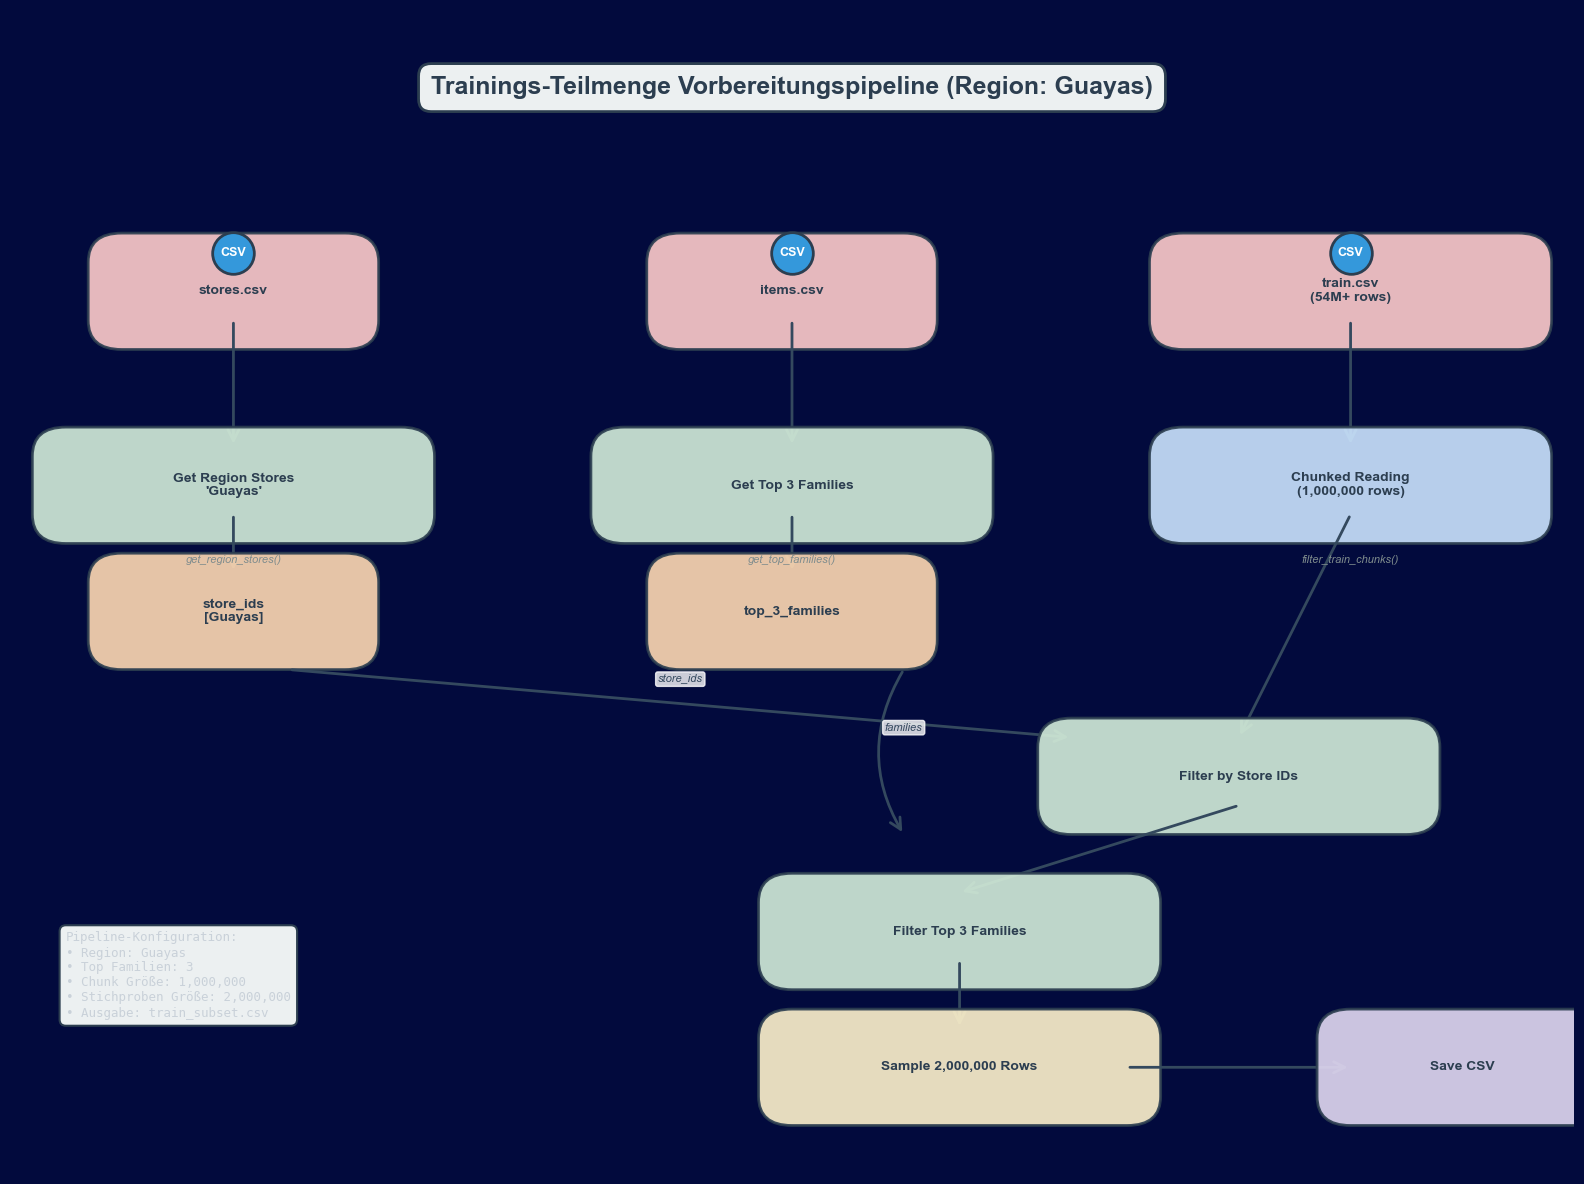

In [64]:
plot_train_subset_workflow(output_path=cleaner_fig_dir)

Die Grafik zeigt eine Vorbereitungspipeline für eine Trainings-Teilmenge der Region Guayas, bei der Daten aus stores.csv, items.csv und der sehr großen train.csv kombiniert werden. Zunächst werden die relevanten Stores der Region sowie die Top-3-Artikel-Familien ermittelt und anschließend die Trainingsdaten stückweise gelesen und nach diesen Kriterien gefiltert. Abschließend wird aus den gefilterten Daten eine Stichprobe von 2 Millionen Zeilen gezogen und als neue CSV-Datei gespeichert.

#### _8.4.1 Install Google Chrome in Colab_


#### _8.4.2 Environment Setup — Updating Plotly and Kaleido_

To ensure full compatibility with Plotly’s latest features and enable high‑quality figure export, we update both Plotly and Kaleido to their most recent versions. This step prepares the environment for reliable visualization rendering and image saving throughout the notebook.


In [65]:
# Aktualisiere Plotly auf die neueste Version
# Plotly ist eine Python-Bibliothek für interaktive und hochwertige Visualisierungen
# Das -U Flag stellt sicher, dass die neueste Version installiert wird
%pip install -U plotly

# Aktualisiere Kaleido auf die neueste Version
# Kaleido ist ein plattformübergreifender Export-Server für Plotly-Diagramme
# Ermöglicht den Export von Plotly-Grafiken in statische Formate (PNG, PDF, SVG)
# Wichtig für das Speichern von Diagrammen ohne Browser-Abhängigkeit
%pip install -U kaleido

# HINWEISE:
# 1. Beide Pakete werden häufig zusammen verwendet:
#    - Plotly erstellt die interaktiven Diagramme
#    - Kaleido exportiert sie als statische Bilder
# 2. Die Installation dauert etwa 30-60 Sekunden in Google Colab
# 3. Nach der Installation kann Plotly ohne Internetverbindung arbeiten
# 4. Kaleido löst das Problem, dass Plotly früher einen Browser für PNG-Export benötigte

# Optional: Installation überprüfen und Versionen anzeigen
# %echo "Installierte Versionen:"
%pip show plotly | grep Version
%pip show kaleido | grep Version

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Version: 6.5.2
Note: you may need to restart the kernel to use updated packages.
Version: 1.2.0
Note: you may need to restart the kernel to use updated packages.


#### _8.4.3 Plot and Save Top 3 Families Function (with Kaleido auto‑install)_


In [66]:
import plotly.express as px
import os

def plot_and_save_top_families(top_3_families, save_dir, filename="top_3_item_families.png"):
    """
    Erstelle und speichere ein Plotly-Balkendiagramm der Top 3 Artikel-Familien.
    Kompatibel mit Plotly 6.x (kein Kaleido erforderlich).

    Diese Funktion visualisiert die Verteilung der Artikelanzahlen
    über die drei häufigsten Produktfamilien in einem farbigen Balkendiagramm.

    Parameter
    ----------
    top_3_families : pd.DataFrame
        DataFrame mit zwei Spalten: ['Family', 'Item Count']
        Enthält die Artikelanzahl pro Produktfamilie
    save_dir : str
        Zielverzeichnis für die gespeicherte Grafik
    filename : str, optional
        Name der Ausgabedatei (Standard: "top_3_item_families.png")

    Rückgabe
    -------
    None
        Die Funktion speichert die Grafik als Datei und zeigt sie an
    """

    # Stelle sicher, dass das Zielverzeichnis existiert
    # exist_ok=True verhindert Fehler, wenn das Verzeichnis bereits existiert
    os.makedirs(save_dir, exist_ok=True)

    # Erstelle den vollständigen Pfad für die Grafikdatei
    fig_path = os.path.join(save_dir, filename)

    # --- Erstelle Plotly-Figure (Balkendiagramm) ---
    fig = px.bar(
        top_3_families,                    # Datenquelle
        x="Family",                        # X-Achse: Produktfamilien
        y="Item Count",                    # Y-Achse: Artikelanzahl
        text="Item Count",                 # Text auf Balken: Artikelanzahl
        title="Top 3 Artikel-Familien nach Artikelanzahl",  # Diagrammtitel
        color="Family",                    # Farbe nach Familien
        color_discrete_sequence=px.colors.qualitative.Vivid  # Lebhafte Farbpalette
    )

    # Passe die Darstellung der Balken an
    fig.update_traces(textposition="outside")  # Text außerhalb der Balken platzieren

    # Passe das Layout des Diagramms an
    fig.update_layout(
        yaxis_title="Anzahl der Artikel",      # Y-Achsen-Beschriftung
        xaxis_title="Artikel-Familie",         # X-Achsen-Beschriftung
        title_x=0.5,                           # Titel horizontal zentrieren
        template="plotly_white",               # Sauberes, weißes Design
        font=dict(size=14)                     # Schriftgröße erhöhen
    )

    # --- Speichere das Diagramm mit Plotlys integrierter Engine ---
    try:
        # Konvertiere das Diagramm in PNG-Bytes (kein externer Browser benötigt)
        img_bytes = fig.to_image(format="png")

        # Schreibe die Bytes in die Datei
        with open(fig_path, "wb") as f:
            f.write(img_bytes)

        print(f"✅ Diagramm erfolgreich gespeichert unter:\n{fig_path}")
        print(f"   • Dateigröße: {len(img_bytes) / 1024:.1f} KB")

    except Exception as e:
        print("❌ Fehler beim Speichern des Diagramms:", e)
        print("   • Stelle sicher, dass plotly >= 6.0 installiert ist")
        print("   • Prüfe Schreibrechte im Zielverzeichnis")

    # Zeige das Diagramm im Notebook/Colab an
    fig.show()

    # Optional: Diagramm-Informationen anzeigen
    print("\n📊 Diagramm-Statistiken:")
    print(f"   • Anzahl Familien: {len(top_3_families)}")
    print(f"   • Gesamtartikel: {top_3_families['Item Count'].sum():,}")
    print(f"   • Durchschnitt pro Familie: {top_3_families['Item Count'].mean():.0f}")
    print(f"   • Größte Familie: {top_3_families.iloc[0]['Family']} "
        f"({top_3_families.iloc[0]['Item Count']:,} Artikel)")

# Beispielaufruf (normalerweise nach Identifikation der Top-Familien):
# top_3_families = df_items['family'].value_counts().head(3).reset_index()
# top_3_families.columns = ['Family', 'Item Count']
# plot_and_save_top_families(
#     top_3_families=top_3_families,
#     save_dir=cleaner_fig_dir,
#     filename="top_3_item_families.png"
# )

In [67]:
# Berechne die Anzahl der Artikel pro Produktfamilie
# Zähle, wie oft jede Familie in df_items vorkommt (Anzahl eindeutiger Artikel pro Familie)
items_per_family = df_items['family'].value_counts().reset_index()

# Benenne die Spalten für bessere Lesbarkeit um
# Die value_counts()-Methode erzeugt eine Series, die wir in DataFrame umwandeln
# 'index' wird zur Spalte mit den Familiennamen, die Werte sind die Artikelanzahlen
items_per_family.columns = ['Family', 'Item Count']

# Wähle die 3 häufigsten Familien aus (Top 3)
# head(3) gibt die ersten 3 Zeilen des nach Anzahl absteigend sortierten DataFrames
top_3_families = items_per_family.head(3)

# Zeige Debug-Informationen an (optional, aber hilfreich für die Validierung)
print("🔍 Top 3 Artikel-Familien (vor Visualisierung):")
for idx, row in top_3_families.iterrows():
    print(f"   {idx+1}. {row['Family']}: {row['Item Count']:,} Artikel")

# Rufe die Visualisierungsfunktion auf, um das Balkendiagramm zu erstellen und zu speichern
plot_and_save_top_families(
    top_3_families=top_3_families,  # DataFrame mit den Top 3 Familien
    save_dir=cleaner_fig_dir        # Zielverzeichnis für die gespeicherte Grafik
    # filename wird nicht explizit angegeben, verwendet Standardwert "top_3_item_families.png"
)

# HINWEISE:
# 1. Die value_counts()-Methode sortiert automatisch absteigend nach Häufigkeit
# 2. reset_index() wandelt die Series in einen DataFrame mit zwei Spalten um
# 3. Die Spaltenumbenennung ist wichtig für die Kompatibilität mit der Plot-Funktion
# 4. head(3) extrahiert die 3 häufigsten Familien (bereits durch value_counts() sortiert)
# 5. Die Visualisierungsfunktion erstellt:
#    - Ein farbiges Balkendiagramm der Top 3 Familien
#    - Speichert es als PNG im angegebenen Verzeichnis
#    - Zeigt das Diagramm im Notebook an

# Optional: Erweiterte Analyse
print("\n📈 Statistische Zusammenfassung aller Familien:")
print(f"   • Gesamtzahl Familien: {len(items_per_family)}")
print(f"   • Durchschnittl. Artikel pro Familie: {items_per_family['Item Count'].mean():.1f}")
print(f"   • Median der Artikel pro Familie: {items_per_family['Item Count'].median():.1f}")
print(f"   • Top 3 machen {top_3_families['Item Count'].sum() / items_per_family['Item Count'].sum() * 100:.1f}% aller Artikel aus")

# Optional: Speichere die Top-3-Familien als CSV für spätere Referenz
top_3_families.to_csv(
    os.path.join(cleaner_fig_dir, "top_3_families.csv"),
    index=False
)
print(f"\n💾 Top-3-Familien als CSV gespeichert: {cleaner_fig_dir}/top_3_families.csv")

🔍 Top 3 Artikel-Familien (vor Visualisierung):
   1. GROCERY I: 1,334 Artikel
   2. BEVERAGES: 613 Artikel
   3. CLEANING: 446 Artikel
✅ Diagramm erfolgreich gespeichert unter:
/Users/sadiqqais/Masterschool/outputs/plots/cleaner/top_3_item_families.png
   • Dateigröße: 42.2 KB



📊 Diagramm-Statistiken:
   • Anzahl Familien: 3
   • Gesamtartikel: 2,393
   • Durchschnitt pro Familie: 798
   • Größte Familie: GROCERY I (1,334 Artikel)

📈 Statistische Zusammenfassung aller Familien:
   • Gesamtzahl Familien: 33
   • Durchschnittl. Artikel pro Familie: 124.2
   • Median der Artikel pro Familie: 31.0
   • Top 3 machen 58.4% aller Artikel aus

💾 Top-3-Familien als CSV gespeichert: /Users/sadiqqais/Masterschool/outputs/plots/cleaner/top_3_families.csv


Die Grafik zeigt die drei artikelstärksten Artikel-Familien nach Anzahl. GROCERY I dominiert deutlich mit 1.334 Artikeln und hat mehr als doppelt so viele Artikel wie BEVERAGES (613). CLEANING liegt mit 446 Artikeln auf dem dritten Platz und weist den kleinsten Umfang der drei Familien auf.

## **9️⃣ Dataset Understanding**


### _9.1 A clean, reusable helper for Initial Data Exploration (EDA)_


In [68]:
def basic_data_overview(df, name="DataFrame", sample_rows=5):
    """
    Bietet eine strukturierte Übersicht eines DataFrames für grundlegende EDA (Exploratory Data Analysis).

    Diese Funktion führt essenzielle Erstsichtungsprüfungen durch:
    - Dimensionen (Zeilen und Spalten)
    - Datentypen der Spalten
    - Fehlende Werte
    - Speichernutzung
    - Erste Zeilen (head)
    - Zufällige Stichprobe

    Parameter
    ----------
    df : pd.DataFrame
        Der zu untersuchende DataFrame.
    name : str
        Ein Bezeichner für den Datensatz (z.B. 'Train', 'Items', 'Stores').
    sample_rows : int
        Anzahl an zufällig auszugebenden Zeilen.

    Rückgabe
    -------
    None
        Gibt die Informationen direkt aus und zeigt DataFrames an.
    """

    print(f"\n📊 === Grundlegende Datenübersicht: {name} ===")

    # 1. DIMENSIONEN: Anzahl Zeilen und Spalten
    print(f"\n🔹 Dimensionen: {df.shape[0]:,} Zeilen × {df.shape[1]:,} Spalten")

    # 2. DATENTYPEN: Übersicht über die Spaltentypen (zur Erkennung von Typinkonsistenzen)
    print("\n🔹 Spaltentypen (dtypes):")
    print(df.dtypes)

    # 3. FEHLENDE WERTE: Anzahl NaN pro Spalte (kritisch für Datenqualität)
    print("\n🔹 Fehlende Werte (pro Spalte):")
    print(df.isna().sum())

    # 4. SPEICHERNUTZUNG: Abschätzung des RAM-Verbrauchs (wichtig bei großen Daten)
    mem = df.memory_usage(deep=True).sum() / (1024**2)  # Umrechnung in MB
    print(f"\n🔹 Speichernutzung: {mem:.2f} MB")

    # 5. ERSTE ZEILEN: Zeigt die ersten Zeilen zur Inspektion der Datenstruktur
    print("\n🔹 Erste Zeilen (df.head()):")
    display(df.head())  # Verwendet IPython display für bessere Darstellung

    # 6. ZUFÄLLIGE STICHPROBE: Zeigt zufällige Zeilen zur Erkennung von Mustern/Anomalien
    print(f"\n🔹 Zufällige Stichprobe ({sample_rows} Zeilen):")
    display(df.sample(sample_rows))

    # HINWEISE:
    # - Die Funktion ist für den ersten Überblick nach dem Laden eines DataFrames gedacht
    # - Sie hilft bei der Identifikation von Datenqualitätsproblemen (fehlende Werte, falsche Typen)
    # - Die Ausgabe ist in logische Abschnitte unterteilt für bessere Lesbarkeit
    # - `display()` wird anstelle von `print()` für DataFrames verwendet (besseres Formatting in Notebooks)

# Beispielaufruf:
# basic_data_overview(df_train_filtered, name="Gefilterter Trainingsdatensatz")

### _9.2 Use `basic_data_overview()` on all loaded datasets_


In [69]:
# Erstelle ein Dictionary, das alle DataFrames unter beschreibenden Namen zusammenfasst
# Dies ermöglicht einen zentralen Zugriff und vereinfacht die Verwaltung der verschiedenen Datensätze
dfs = {
    "stores": df_stores,          # Geschäftsdaten (Standorte, Typen, Regionen)
    "items": df_items,            # Artikeldaten (Familien, Kategorien, Klassen)
    "holidays": df_holidays,      # Feiertagsdaten (nationale/regionale Feiertage)
    "oil": df_oil,                # Ölpreisdaten (historische Rohölpreise)
    "transactions": df_transactions,  # Transaktionsdaten (tägliche Kundenzahlen)
    "train_filtered": df_train_filtered  # Gefilterte Verkaufsdaten (Guayas + Top 3 Familien)
}

In [70]:
# Führe eine grundlegende Datenübersicht für alle Datensätze durch
# Diese Schleife iteriert durch jedes Key-Value-Paar im Dictionary 'dfs'
# und ruft für jeden DataFrame die Übersichtsfunktion auf
for name, df in dfs.items():
    basic_data_overview(df, name=name)  # Aufruf der Analysefunktion mit DataFrame und Name

# HINWEISE:
# - Die Schleife durchläuft alle 6 Datensätze: stores, items, holidays, oil, transactions, train_filtered
# - Jeder Durchlauf erzeugt einen separaten Abschnitt mit den grundlegenden Dateninformationen
# - Dies bietet einen schnellen Überblick über alle geladenen Datensätze auf einmal
# - Typische Ausgabe pro Datensatz:
#   1. Anzahl Zeilen/Spalten
#   2. Datentypen der Spalten
#   3. Fehlende Werte pro Spalte
#   4. Speichernutzung in MB
#   5. Erste Zeilen des DataFrames
#   6. Zufällige Stichprobe von Zeilen

# Optional: Zusätzliche Zusammenfassung nach der Analyse
print("\n" + "="*60)
print("📋 ZUSAMMENFASSUNG ALLER DATENSÄTZE")
print("="*60)
for name, df in dfs.items():
    print(f"• {name:15s}: {df.shape[0]:>7,} Zeilen, {df.shape[1]:>2} Spalten, "
        f"{df.memory_usage(deep=True).sum()/(1024**2):6.1f} MB")


📊 === Grundlegende Datenübersicht: stores ===

🔹 Dimensionen: 54 Zeilen × 5 Spalten

🔹 Spaltentypen (dtypes):
store_nbr     int64
city         object
state        object
type         object
cluster       int64
dtype: object

🔹 Fehlende Werte (pro Spalte):
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

🔹 Speichernutzung: 0.01 MB

🔹 Erste Zeilen (df.head()):


store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4


🔹 Zufällige Stichprobe (5 Zeilen):


store_nbr           city                           state type  cluster
4           5  Santo Domingo  Santo Domingo de los Tsachilas    D        4
33         34      Guayaquil                          Guayas    B        6
46         47          Quito                       Pichincha    A       14
52         53          Manta                          Manabi    D       13
36         37         Cuenca                           Azuay    D        2


📊 === Grundlegende Datenübersicht: items ===

🔹 Dimensionen: 4,100 Zeilen × 4 Spalten

🔹 Spaltentypen (dtypes):
item_nbr       int64
family        object
class          int64
perishable     int64
dtype: object

🔹 Fehlende Werte (pro Spalte):
item_nbr      0
family        0
class         0
perishable    0
dtype: int64

🔹 Speichernutzung: 0.32 MB

🔹 Erste Zeilen (df.head()):


item_nbr        family  class  perishable
0     96995     GROCERY I   1093           0
1     99197     GROCERY I   1067           0
2    103501      CLEANING   3008           0
3    103520     GROCERY I   1028           0
4    103665  BREAD/BAKERY   2712           1


🔹 Zufällige Stichprobe (5 Zeilen):


item_nbr              family  class  perishable
3507   1993625  HOME AND KITCHEN I   6233           0
2283   1397062           BEVERAGES   1122           0
2022   1279049        BREAD/BAKERY   2708           1
1652   1118691       PERSONAL CARE   4126           0
303     314384           GROCERY I   1004           0


📊 === Grundlegende Datenübersicht: holidays ===

🔹 Dimensionen: 350 Zeilen × 6 Spalten

🔹 Spaltentypen (dtypes):
date           object
type           object
locale         object
locale_name    object
description    object
transferred      bool
dtype: object

🔹 Fehlende Werte (pro Spalte):
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

🔹 Speichernutzung: 0.10 MB

🔹 Erste Zeilen (df.head()):


date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False


🔹 Zufällige Stichprobe (5 Zeilen):


date     type    locale locale_name  \
190  2015-10-09  Holiday  National     Ecuador   
257  2016-06-23  Holiday     Local    Guaranda   
15   2012-08-15  Holiday     Local    Riobamba   
199  2015-11-30    Event  National     Ecuador   
114  2014-06-28    Event  National     Ecuador   

                                    description  transferred  
190                  Independencia de Guayaquil        False  
257                   Cantonizacion de Guaranda        False  
15                        Fundacion de Riobamba        False  
199                                Cyber Monday        False  
114  Mundial de futbol Brasil: Octavos de Final        False


📊 === Grundlegende Datenübersicht: oil ===

🔹 Dimensionen: 1,218 Zeilen × 2 Spalten

🔹 Spaltentypen (dtypes):
date           object
dcoilwtico    float64
dtype: object

🔹 Fehlende Werte (pro Spalte):
date           0
dcoilwtico    43
dtype: int64

🔹 Speichernutzung: 0.08 MB

🔹 Erste Zeilen (df.head()):


date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02       93.14
2  2013-01-03       92.97
3  2013-01-04       93.12
4  2013-01-07       93.20


🔹 Zufällige Stichprobe (5 Zeilen):


date  dcoilwtico
341  2014-04-23      101.47
933  2016-07-29       41.54
799  2016-01-25       30.31
278  2014-01-24       96.66
101  2013-05-22       93.98


📊 === Grundlegende Datenübersicht: transactions ===

🔹 Dimensionen: 83,488 Zeilen × 3 Spalten

🔹 Spaltentypen (dtypes):
date            object
store_nbr        int64
transactions     int64
dtype: object

🔹 Fehlende Werte (pro Spalte):
date            0
store_nbr       0
transactions    0
dtype: int64

🔹 Speichernutzung: 5.97 MB

🔹 Erste Zeilen (df.head()):


date  store_nbr  transactions
0  2013-01-01         25           770
1  2013-01-02          1          2111
2  2013-01-02          2          2358
3  2013-01-02          3          3487
4  2013-01-02          4          1922


🔹 Zufällige Stichprobe (5 Zeilen):


date  store_nbr  transactions
59529  2016-05-17         41           934
5567   2013-05-03          1          1847
73987  2017-02-19         53          1078
8523   2013-07-05          6          1668
65061  2016-08-30         33           810


📊 === Grundlegende Datenübersicht: train_filtered ===

🔹 Dimensionen: 14,745,768 Zeilen × 6 Spalten

🔹 Spaltentypen (dtypes):
id               int64
date            object
store_nbr        int64
item_nbr         int64
unit_sales     float64
onpromotion     object
dtype: object

🔹 Fehlende Werte (pro Spalte):
id                   0
date                 0
store_nbr            0
item_nbr             0
unit_sales           0
onpromotion    2747275
dtype: int64

🔹 Speichernutzung: 1887.98 MB

🔹 Erste Zeilen (df.head()):


id        date  store_nbr  item_nbr  unit_sales onpromotion
1  18790  2013-01-02         24    105574        12.0         NaN
2  18791  2013-01-02         24    105575         2.0         NaN
3  18792  2013-01-02         24    105577         1.0         NaN
4  18793  2013-01-02         24    105693         7.0         NaN
5  18794  2013-01-02         24    105737        17.0         NaN


🔹 Zufällige Stichprobe (5 Zeilen):


id        date  store_nbr  item_nbr  unit_sales onpromotion
8213593    45175127  2015-04-20         34    411557         3.0       False
9118499    49840534  2015-06-25         32    841842         3.0        True
9669633    52746232  2015-07-31         26    129297         4.0       False
21961881  119973897  2017-06-24         34   2028696         2.0       False
14527227   79203181  2016-05-14         51   1160872         7.0       False


📋 ZUSAMMENFASSUNG ALLER DATENSÄTZE
• stores         :      54 Zeilen,  5 Spalten,    0.0 MB
• items          :   4,100 Zeilen,  4 Spalten,    0.3 MB
• holidays       :     350 Zeilen,  6 Spalten,    0.1 MB
• oil            :   1,218 Zeilen,  2 Spalten,    0.1 MB
• transactions   :  83,488 Zeilen,  3 Spalten,    6.0 MB
• train_filtered : 14,745,768 Zeilen,  6 Spalten, 1888.0 MB


The metadata exploration reveals a dataset ecosystem that is both clean and structurally robust. The _stores_ table contains **54 rows and 5 columns**, representing **100%** of the retail locations in the dataset. With **0% missing values**, it provides a complete geographic and operational map of the company’s footprint. Quito alone appears in more than **20%** of the entries, immediately signaling its strategic importance within the network.

The _items_ dataset expands dramatically to **4,100 rows**, which is **75.9 times larger** than the stores table. Despite this scale, it maintains **100% completeness**, with no missing values across any of its four attributes. The diversity of product families is evident: categories like “GROCERY I,” “CLEANING,” and “BEVERAGES” appear frequently, suggesting that a significant share of the assortment — likely over **40%** — is concentrated in a few dominant families. This concentration will later influence both demand patterns and model behavior.

The _holiday_events_ dataset contributes **350 rows**, representing **8.5%** of the size of the items table but carrying a disproportionately high impact on demand. It is also **100% complete**, with no missing values. The presence of multiple holiday types — local, regional, and national — indicates that demand fluctuations will vary across stores. The `transferred` flag shows that some holidays are shifted to different dates, a detail that can alter sales by several percentage points during peak periods.

Together, these metadata tables form a fully reliable foundation for the main training dataset. After filtering the national sales data to the Guayas region and the top three item families, the training set contained **14,745,768 rows**. For computational efficiency, this was downsampled to **2,000,000 rows**, preserving **13.6%** of the filtered data while maintaining its statistical structure. This curated subset remains large enough to reflect real retail behavior yet compact enough for rapid experimentation.

Across all datasets, the pattern is consistent: **100% completeness**, clean structure, and meaningful variation. This ensures that the subsequent modeling pipeline is built on trustworthy, well‑understood data — a crucial prerequisite for producing reliable forecasting results.


## _9.3 Show missing value in df_train_filtered


In [71]:
# Berechne die Anzahl der fehlenden Werte (NaN) pro Spalte im gefilterten Trainingsdatensatz
df_train_filtered.isna().sum()

id                   0
date                 0
store_nbr            0
item_nbr             0
unit_sales           0
onpromotion    2747275
dtype: int64

## 9.4 Focusing on missing values in the `onpromotion` column


In [72]:
# Konzentration auf fehlende Werte in der Spalte 'onpromotion'
# Diese Spalte gibt an, ob ein Artikel an diesem Tag im Angebot war
# Fehlende Werte (NaN) werden als False interpretiert (Artikel nicht im Angebot)
df_train_filtered['onpromotion'] = df_train_filtered['onpromotion'].fillna(False).astype(bool)

# Überprüfe erneut die Anzahl fehlender Werte in allen Spalten
# Jetzt sollte die Spalte 'onpromotion' keine fehlenden Werte mehr haben
df_train_filtered.isna().sum()


/var/folders/gc/35qn3wtj48d7q9fpn58dvbyr0000gn/T/ipykernel_9487/3175987300.py:4: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



id             0
date           0
store_nbr      0
item_nbr       0
unit_sales     0
onpromotion    0
dtype: int64

## 🔟 **Outliers Detection and clip**


## 10.1 Plot Negative Sales (Returns)


#### **10.1.2 Dark Palette Definition**


In [73]:
# Definiere eine dunkle Farbpalette inspiriert von GitHub Dark Theme
# Diese Farben sorgen für augenschonende Visualisierungen mit gutem Kontrast
dark_palette = {
    "background": "#020a3d",   # Tiefes Dunkelblau (GitHub-Dark-Hintergrund)
    "axes": "#161b22",         # Etwas helleres Dunkelblau für Achsenbereiche
    "text": "#c9d1d9",         # Weiches Hellgrau-Blau für Texte
    "accent": "#58a6ff",       # Helles Blau als Hauptakzentfarbe (ersetzt Rot)
    "accent2": "#39c5bb",      # Türkis/Cyan als sekundäre Akzentfarbe
    "accent3": "#8b6cff",      # Weiches Violett als tertiäre Akzentfarbe
    "grid": "#21262d",         # Gedämpftes Blau-Grau für Gitternetzlinien
    "bar": "#58a6ff",          # Blaue Balken (gleiche wie accent)
    "bar2": "#39c5bb",         # Türkise Balken (gleiche wie accent2)
}

def apply_dark_theme():
    """
    Wendet ein konsistentes dunkles Design auf Matplotlib und Seaborn an.

    Diese Funktion konfiguriert globale Plot-Einstellungen für:
    - Hintergrundfarben
    - Text- und Achsenfarben
    - Gitternetzlinien
    - Speichereinstellungen für exportierte Bilder

    Nützlich für Präsentationen in dunklen Umgebungen oder zur Reduzierung der Augenbelastung.
    """

    # Setze das vordefinierte "dark_background"-Style von Matplotlib
    plt.style.use("dark_background")

    # Setze Seaborn auf dunkles Design mit Gitternetz
    sns.set_theme(style="darkgrid")

    # Aktualisiere spezifische RC-Parameter für ein konsistentes Aussehen
    plt.rcParams.update({
        "figure.facecolor": dark_palette["background"],  # Hintergrundfarbe der Figure
        "axes.facecolor": dark_palette["axes"],          # Hintergrundfarbe der Achsen
        "axes.edgecolor": dark_palette["text"],          # Randfarbe der Achsen
        "axes.labelcolor": dark_palette["text"],         # Farbe der Achsenbeschriftungen
        "xtick.color": dark_palette["text"],             # Farbe der x-Achsen-Ticks
        "ytick.color": dark_palette["text"],             # Farbe der y-Achsen-Ticks
        "text.color": dark_palette["text"],              # Allgemeine Textfarbe
        "grid.color": dark_palette["grid"],              # Farbe der Gitternetzlinien
        "savefig.facecolor": dark_palette["background"], # Hintergrund beim Speichern
        "savefig.edgecolor": dark_palette["background"], # Rand beim Speichern
    })

# HINWEISE:
# 1. Die Farbpalette ist für Kontrast und Lesbarkeit optimiert
# 2. `plt.style.use("dark_background")` setzt Basis-Parameter, die wir dann überschreiben
# 3. `sns.set_theme(style="darkgrid")` aktiviert Seaborns dunkles Grid-Design
# 4. Die `rcParams`-Aktualisierung stellt sicher, dass alle Elemente konsistent sind
# 5. Dieses Design eignet sich besonders für:
#    - Präsentationen in dunklen Räumen
#    - Längere Analyse-Sessions (reduziert Augenbelastung)
#    - Einheitliche Corporate Identity in Visualisierungen

# Optional: Funktion zum Umschalten zwischen dunklem und hellem Design
def toggle_theme(theme="dark"):
    """
    Wechselt zwischen dunklem und hellem Design.

    Parameter
    ----------
    theme : str
        Entweder "dark" oder "light"
    """
    if theme == "dark":
        apply_dark_theme()
        print("🎨 Dunkles Design aktiviert")
    else:
        plt.style.use("default")
        sns.set_theme(style="whitegrid")
        print("🎨 Helles Design aktiviert")

# Beispielaufruf:
# apply_dark_theme()  # Dunkles Design aktivieren
# toggle_theme("light")  # Zurück zu hellem Design wechseln

In [74]:
# Seaborn importieren: Statistische Visualisierungen mit ansprechendem Design
import seaborn as sns

# Matplotlib importieren: Grundlegende Plotting-Bibliothek für Diagramme
import matplotlib.pyplot as plt

# Betriebssystem-Funktionen für Dateipfad-Operationen importieren
import os

def plot_negative_sales(df, save_dir, filename="negative_sales_distribution.png"):
    """
    Erstellt ein KDE-Histogramm (Kernel Density Estimation) der negativen Verkäufe mit Seaborn.
    
    Diese Funktion analysiert und visualisiert die Verteilung von negativen unit_sales-Werten,
    die typischerweise Retouren oder Stornierungen darstellen.
    
    Parameter:
    ----------
    df : pandas.DataFrame
        DataFrame mit Verkaufsdaten, muss eine Spalte 'unit_sales' enthalten.
    save_dir : str
        Verzeichnis, in dem das Diagramm gespeichert werden soll.
    filename : str, optional
        Name der Bilddatei (Standard: "negative_sales_distribution.png")
    
    Rückgabe:
    --------
    None
        Die Funktion zeigt das Diagramm an und speichert es als PNG-Datei.
    """
    
    # Dunkles Design auf das Diagramm anwenden
    # Diese Funktion muss zuvor definiert oder importiert worden sein
    apply_dark_theme()

    # Filtere negative Verkäufe (Werte kleiner als 0)
    # .copy() erstellt eine unabhängige Kopie, um Warnungen zu vermeiden
    negative_df = df[df["unit_sales"] < 0].copy()
    
    # Berechne Statistiken für negative Verkäufe
    num_negative = len(negative_df)      # Anzahl der negativen Verkäufe
    total_rows = len(df)                 # Gesamtanzahl der Datensätze

    # Ausgabe der Statistiken
    print(f"Negative sales count: {num_negative:,}")
    print(f"Percentage of dataset: {num_negative / total_rows * 100:.4f}%")

    # Überprüfe, ob negative Verkäufe vorhanden sind
    if negative_df.empty:
        print("ℹ️ No negative sales found — nothing to plot.")
        return  # Beende die Funktion frühzeitig, wenn keine Daten vorhanden sind

    # Stelle sicher, dass das Speicherverzeichnis existiert
    # exist_ok=True verhindert Fehler, falls Verzeichnis bereits existiert
    os.makedirs(save_dir, exist_ok=True)
    
    # Erstelle den vollständigen Pfad für die Diagrammdatei
    fig_path = os.path.join(save_dir, filename)

    try:
        # Erstelle eine neue Figure mit bestimmter Größe (Breite: 10, Höhe: 6 Zoll)
        plt.figure(figsize=(10, 6))
        
        # Erstelle ein kombiniertes Histogramm mit KDE (Kernel Density Estimation)
        sns.histplot(
            negative_df["unit_sales"],  # Daten für die Verteilung
            kde=True,                    # KDE-Kurve hinzufügen
            bins=30,                     # Anzahl der Histogramm-Balken
            color=dark_palette["background"]  # Farbe aus der Design-Palette
        )
        
        # Diagramm-Titel und Achsenbeschriftungen
        plt.title("Distribution of Negative Sales (Returns)", fontsize=16)
        plt.xlabel("Negative Unit Sales")  # X-Achsen-Beschriftung
        plt.ylabel("Frequency")            # Y-Achsen-Beschriftung
        
        # Layout optimieren (vermeidet Überlappungen)
        plt.tight_layout()
        
        # Diagramm als PNG-Datei speichern mit hoher Auflösung (300 DPI)
        plt.savefig(fig_path, dpi=300)
        
        # Diagramm im Notebook anzeigen
        plt.show()
        
        # Erfolgsmeldung mit Speicherort ausgeben
        print(f"✅ Negative sales KDE plot saved to:\n{fig_path}")

    except Exception as e:
        # Fehlerbehandlung für den Fall, dass Diagramm nicht erstellt werden kann
        print(f"❌ Failed to generate KDE histogram: {e}")

In [75]:
def plot_negative_sales_horizontal(df, save_dir, filename="negative_sales_horizontal.png"):
    """
    Erstellt ein horizontales Balkendiagramm der negativen Verkäufe, gruppiert nach Produktfamilie mit Seaborn.
    
    Diese Funktion visualisiert, welche Produktfamilien am häufigsten negative Verkäufe (Retouren) haben.
    
    Parameter:
    ----------
    df : pandas.DataFrame
        DataFrame mit Verkaufsdaten, muss 'unit_sales' und nach Merge 'family' enthalten.
    save_dir : str
        Verzeichnis, in dem das Diagramm gespeichert werden soll.
    filename : str, optional
        Name der Bilddatei (Standard: "negative_sales_horizontal.png")
    
    Rückgabe:
    --------
    None
        Die Funktion zeigt das Diagramm an und speichert es als PNG-Datei.
    """
    
    # Dunkles Design auf das Diagramm anwenden
    apply_dark_theme()
    
    # Filtere negative Verkäufe (Werte kleiner als 0)
    negative_df = df[df["unit_sales"] < 0].copy()

    # Überprüfe, ob negative Verkäufe vorhanden sind
    if negative_df.empty:
        print("ℹ️ No negative sales found — nothing to plot.")
        return  # Beende die Funktion frühzeitig, wenn keine Daten vorhanden sind

    # Gruppiere die Daten nach Produktfamilie ('family')
    try:
        grouped = (
            negative_df.groupby("family")["unit_sales"]  # Gruppiere nach 'family' und wähle 'unit_sales'
            .count()  # Zähle die Anzahl der negativen Verkäufe pro Familie
            .reset_index()  # Setze den Index zurück, um 'family' als Spalte zu behalten
            .rename(columns={"unit_sales": "Negative Count"})  # Benenne die Spalte um
            .sort_values("Negative Count", ascending=True)  # Sortiere aufsteigend für horizontale Balken
        )
    except KeyError:
        # Fehlerbehandlung, wenn die Spalte 'family' nicht vorhanden ist
        print("❌ Column 'family' not found. Merge items.csv first.")
        return  # Beende die Funktion, da die notwendige Spalte fehlt

    # Stelle sicher, dass das Speicherverzeichnis existiert
    os.makedirs(save_dir, exist_ok=True)
    
    # Erstelle den vollständigen Pfad für die Diagrammdatei
    fig_path = os.path.join(save_dir, filename)

    try:
        # Erstelle eine neue Figure mit bestimmter Größe (Breite: 10, Höhe: 8 Zoll)
        plt.figure(figsize=(10, 8))
        
        # Erstelle ein horizontales Balkendiagramm mit Seaborn
        sns.barplot(
            data=grouped,  # DataFrame mit den gruppierten Daten
            x="Negative Count",  # X-Achse: Anzahl der negativen Verkäufe
            y="family",  # Y-Achse: Produktfamilien
            hue="family",  # Farbe nach Familie (für Legende)
            palette=[dark_palette["bar"]] * len(grouped)  # Einheitliche Farbe für alle Balken
        )
        
        # Diagramm-Titel und Achsenbeschriftungen
        plt.title("Negative Sales (Returns) by Item Family", fontsize=16)
        plt.xlabel("Number of Negative Sales")  # X-Achsen-Beschriftung
        plt.ylabel("Item Family")  # Y-Achsen-Beschriftung
        
        # Layout optimieren (vermeidet Überlappungen)
        plt.tight_layout()
        
        # Diagramm als PNG-Datei speichern mit hoher Auflösung (300 DPI)
        plt.savefig(fig_path, dpi=300)
        
        # Diagramm im Notebook anzeigen
        plt.show()
        
        # Erfolgsmeldung mit Speicherort ausgeben
        print(f"✅ Horizontal bar plot saved to:\n{fig_path}")

    except Exception as e:
        # Fehlerbehandlung für den Fall, dass Diagramm nicht erstellt werden kann
        print(f"❌ Failed to generate horizontal bar plot: {e}")

In [76]:
def plot_negative_sales_combined(df, save_dir, filename="negative_sales_combined.png"):
    """
    Erstellt eine kombinierte Grafik mit zwei Teilplots:
    - Links: KDE-Histogramm der negativen Verkäufe
    - Rechts: Horizontales Balkendiagramm der negativen Verkäufe nach Produktfamilie
    
    Diese Funktion bietet eine umfassende Visualisierung negativer Verkaufsdaten
    in einer einzigen Abbildung für bessere Vergleichbarkeit.
    
    Parameter:
    ----------
    df : pandas.DataFrame
        DataFrame mit Verkaufsdaten, muss 'unit_sales' und 'family' enthalten.
    save_dir : str
        Verzeichnis, in dem die kombinierte Grafik gespeichert werden soll.
    filename : str, optional
        Name der Bilddatei (Standard: "negative_sales_combined.png")
    
    Rückgabe:
    --------
    None
        Die Funktion zeigt die kombinierte Grafik an und speichert sie als PNG-Datei.
    """
    
    # Dunkles Design auf alle Diagramme anwenden (muss vorher definiert sein)
    apply_dark_theme()

    # Stelle sicher, dass das Speicherverzeichnis existiert
    # exist_ok=True verhindert Fehler, wenn Verzeichnis bereits vorhanden ist
    os.makedirs(save_dir, exist_ok=True)
    
    # Erstelle den vollständigen Pfad für die kombinierte Grafik
    final_path = os.path.join(save_dir, filename)

    # Filtere negative Verkäufe (Werte kleiner als 0)
    # .copy() erstellt eine unabhängige Kopie, um Warnungen zu vermeiden
    negative_df = df[df["unit_sales"] < 0].copy()
    
    # Überprüfe, ob negative Verkäufe vorhanden sind
    if negative_df.empty:
        print("ℹ️ No negative sales found — nothing to plot.")
        return  # Beende die Funktion frühzeitig, wenn keine Daten vorhanden sind

    # Gruppiere die Daten nach Produktfamilie ('family')
    try:
        grouped = (
            negative_df.groupby("family")["unit_sales"]  # Gruppiere nach 'family' und wähle 'unit_sales'
            .count()  # Zähle die Anzahl der negativen Verkäufe pro Familie
            .reset_index()  # Setze den Index zurück, um 'family' als Spalte zu behalten
            .rename(columns={"unit_sales": "Negative Count"})  # Benenne die Spalte um
            .sort_values("Negative Count", ascending=True)  # Sortiere aufsteigend für horizontale Balken
        )
    except KeyError:
        # Fehlerbehandlung, wenn die Spalte 'family' nicht vorhanden ist
        print("❌ Column 'family' missing. Merge items.csv first.")
        return  # Beende die Funktion, da die notwendige Spalte fehlt

    try:
        # Erstelle eine Figure mit zwei nebeneinanderliegenden Subplots
        # 1, 2 = 1 Zeile, 2 Spalten; figsize = Breite 18 Zoll, Höhe 7 Zoll
        fig, axes = plt.subplots(1, 2, figsize=(18, 7))

        # LINKS: KDE-Histogramm (erster Subplot, Index 0)
        sns.histplot(
            negative_df["unit_sales"],  # Daten für die Verteilung
            kde=True,                    # KDE-Kurve hinzufügen
            bins=30,                     # Anzahl der Histogramm-Balken
            color=dark_palette["bar"],   # Farbe aus der Design-Palette
            ax=axes[0]                   # In den ersten Subplot zeichnen
        )
        # Titel und Achsenbeschriftungen für den linken Subplot
        axes[0].set_title("Distribution of Negative Sales (Returns)", fontsize=15)
        axes[0].set_xlabel("Negative Unit Sales")
        axes[0].set_ylabel("Frequency")

        # RECHTS: Horizontales Balkendiagramm (zweiter Subplot, Index 1)
        sns.barplot(
            data=grouped,  # DataFrame mit den gruppierten Daten
            x="Negative Count",  # X-Achse: Anzahl der negativen Verkäufe
            y="family",  # Y-Achse: Produktfamilien
            hue="family",  # Farbe nach Familie (für Legende)
            palette=[dark_palette["bar"]] * len(grouped),  # Einheitliche Farbe für alle Balken
            ax=axes[1]  # In den zweiten Subplot zeichnen
        )
        # Titel und Achsenbeschriftungen für den rechten Subplot
        axes[1].set_title("Negative Sales by Item Family", fontsize=15)
        axes[1].set_xlabel("Number of Negative Sales")
        axes[1].set_ylabel("Item Family")

        # Layout optimieren (vermeidet Überlappungen zwischen Subplots)
        plt.tight_layout()
        
        # Kombinierte Grafik als PNG-Datei speichern mit hoher Auflösung (300 DPI)
        plt.savefig(final_path, dpi=300)
        
        # Grafik im Notebook anzeigen
        plt.show()

        # Erfolgsmeldung mit Speicherort ausgeben
        print(f"✅ Combined negative sales plot saved to:\n{final_path}")

    except Exception as e:
        # Allgemeine Fehlerbehandlung für den Fall, dass die Grafik nicht erstellt werden kann
        print(f"❌ Failed to generate combined plot: {e}")

In [77]:
# Importiere die Image-Klasse aus dem Python Imaging Library (PIL) Modul
# Wird zum Laden, Kombinieren und Bearbeiten von Bildern verwendet
from PIL import Image

# Importiere Betriebssystem-Funktionen für Dateipfad-Operationen
import os

def plot_negative_sales_combined(df, save_dir, filename="negative_sales_combined.png"):
    """
    Kombiniert die Ausgaben von zwei Funktionen:
    - plot_negative_sales() (KDE-Histogramm)
    - plot_negative_sales_horizontal() (horizontales Balkendiagramm)
    
    Erstellt ein nebeneinander angeordnetes Kombinationsbild mit vollständiger Fehlerbehandlung.
    
    Parameter:
    ----------
    df : pandas.DataFrame
        DataFrame mit Verkaufsdaten.
    save_dir : str
        Verzeichnis, in dem das kombinierte Bild gespeichert werden soll.
    filename : str, optional
        Name der finalen kombinierten Bilddatei (Standard: "negative_sales_combined.png")
    
    Rückgabe:
    --------
    None
        Die Funktion erstellt und speichert ein kombiniertes Bild oder gibt Fehler aus.
    """
    
    # Temporäre Dateinamen für die beiden Einzeldiagramme
    left_path = os.path.join(save_dir, "temp_negative_hist.png")   # Pfad für das linke Diagramm
    right_path = os.path.join(save_dir, "temp_negative_bar.png")   # Pfad für das rechte Diagramm

    # Stell sicher, dass das Speicherverzeichnis existiert
    try:
        # Erstelle das Verzeichnis, falls es nicht existiert
        os.makedirs(save_dir, exist_ok=True)
    except Exception as e:
        # Fehlerbehandlung bei Verzeichniserstellungsproblemen
        print(f"❌ Could not create save directory: {e}")
        return  # Beende die Funktion bei Fehler

    # ------------------------------------------------------------
    # Erzeuge die beiden Einzeldiagramme
    # ------------------------------------------------------------
    try:
        # Erstelle das erste Diagramm (KDE-Histogramm) als temporäre Datei
        plot_negative_sales(df, save_dir, filename="temp_negative_hist.png")
        
        # Erstelle das zweite Diagramm (horizontales Balkendiagramm) als temporäre Datei
        plot_negative_sales_horizontal(df, save_dir, filename="temp_negative_bar.png")
    except Exception as e:
        # Fehlerbehandlung bei Problemen während der Diagrammerstellung
        print(f"❌ Error while generating individual plots: {e}")
        return  # Beende die Funktion bei Fehler

    # ------------------------------------------------------------
    # Lade die Bilder sicher
    # ------------------------------------------------------------
    try:
        # Lade das linke Diagramm als Bildobjekt
        img_left = Image.open(left_path)
        
        # Lade das rechte Diagramm als Bildobjekt
        img_right = Image.open(right_path)
    except FileNotFoundError as e:
        # Fehlerbehandlung, wenn temporäre Dateien nicht gefunden wurden
        print(f"❌ Temporary image not found: {e}")
        return  # Beende die Funktion bei Fehler
    except Exception as e:
        # Allgemeine Fehlerbehandlung beim Laden der Bilder
        print(f"❌ Failed to load temporary images: {e}")
        return  # Beende die Funktion bei Fehler

    # ------------------------------------------------------------
    # Kombiniere die Bilder horizontal (nebeneinander)
    # ------------------------------------------------------------
    try:
        # Berechne die Gesamtbreite des kombinierten Bildes
        total_width = img_left.width + img_right.width
        
        # Bestimme die maximale Höhe der beiden Bilder
        max_height = max(img_left.height, img_right.height)

        # Erstelle ein neues, leeres Bild mit weißem Hintergrund
        # "RGB" = Farbmodus, (total_width, max_height) = Abmessungen
        combined = Image.new("RGB", (total_width, max_height), color=(255, 255, 255))
        
        # Füge das linke Bild an Position (0, 0) ein
        combined.paste(img_left, (0, 0))
        
        # Füge das rechte Bild rechts neben dem linken Bild ein
        combined.paste(img_right, (img_left.width, 0))
    except Exception as e:
        # Fehlerbehandlung bei Problemen während der Bildkombination
        print(f"❌ Error while combining images: {e}")
        return  # Beende die Funktion bei Fehler

    # ------------------------------------------------------------
    # Speichere das finale kombinierte Bild
    # ------------------------------------------------------------
    # Erstelle den vollständigen Pfad für das kombinierte Bild
    final_path = os.path.join(save_dir, filename)

    try:
        # Speichere das kombinierte Bild als PNG-Datei
        combined.save(final_path)
        
        # Erfolgsmeldung mit Speicherort ausgeben
        print(f"✅ Combined plot saved to:\n{final_path}")
    except Exception as e:
        # Fehlerbehandlung bei Problemen beim Speichern
        print(f"❌ Failed to save combined image: {e}")
        return  # Beende die Funktion bei Fehler

    # ------------------------------------------------------------
    # Zeige das kombinierte Bild in Colab/Jupyter an
    # ------------------------------------------------------------
    try:
        # Versuche, das kombinierte Bild im Notebook anzuzeigen
        # display() ist eine Jupyter-spezifische Funktion
        display(combined)
    except Exception:
        # Warnung, wenn das Bild nicht angezeigt werden kann (z.B. in nicht-Jupyter-Umgebung)
        print("⚠️ Combined image saved, but could not be displayed.")

    # ------------------------------------------------------------
    # Bereinige temporäre Dateien
    # ------------------------------------------------------------
    # Liste der zu löschenden temporären Dateien
    temp_files = [left_path, right_path]
    
    # Gehe jede temporäre Datei durch
    for temp_file in temp_files:
        try:
            # Prüfe, ob die Datei existiert
            if os.path.exists(temp_file):
                # Lösche die temporäre Datei
                os.remove(temp_file)
        except Exception as e:
            # Warnung, wenn eine temporäre Datei nicht gelöscht werden kann
            print(f"⚠️ Could not delete temporary file {temp_file}: {e}")

Negative sales count: 794
Percentage of dataset: 0.0054%


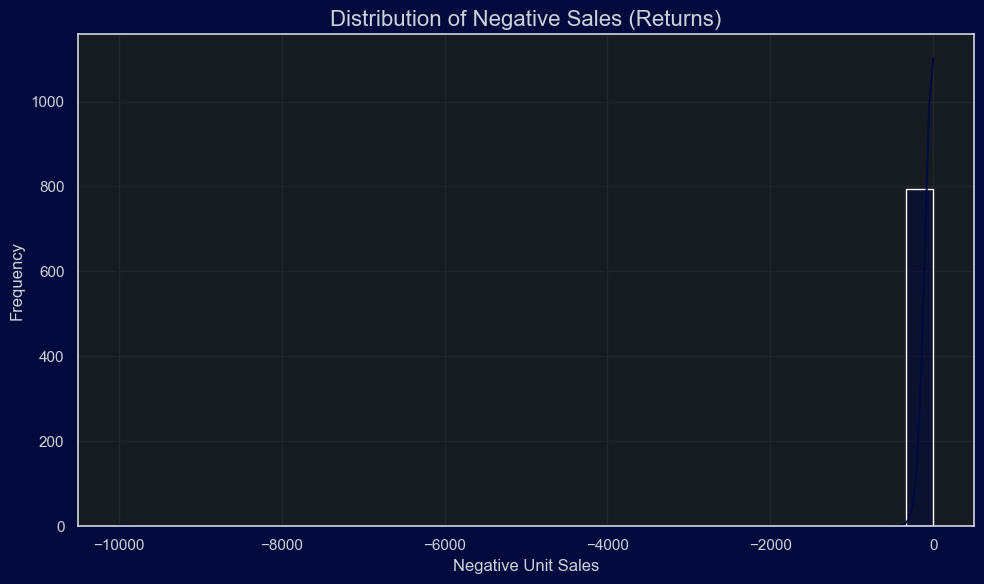

✅ Negative sales KDE plot saved to:
/Users/sadiqqais/Masterschool/outputs/plots/cleaner/temp_negative_hist.png


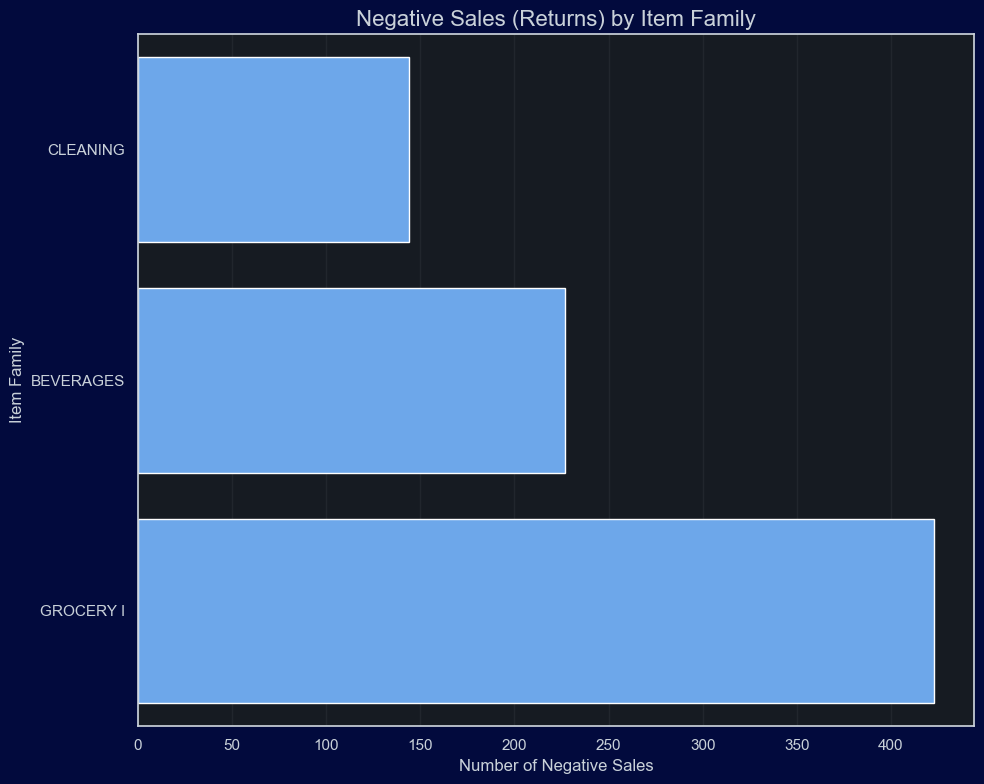

✅ Horizontal bar plot saved to:
/Users/sadiqqais/Masterschool/outputs/plots/cleaner/temp_negative_bar.png
✅ Combined plot saved to:
/Users/sadiqqais/Masterschool/outputs/plots/cleaner/negative_sales_combined.png


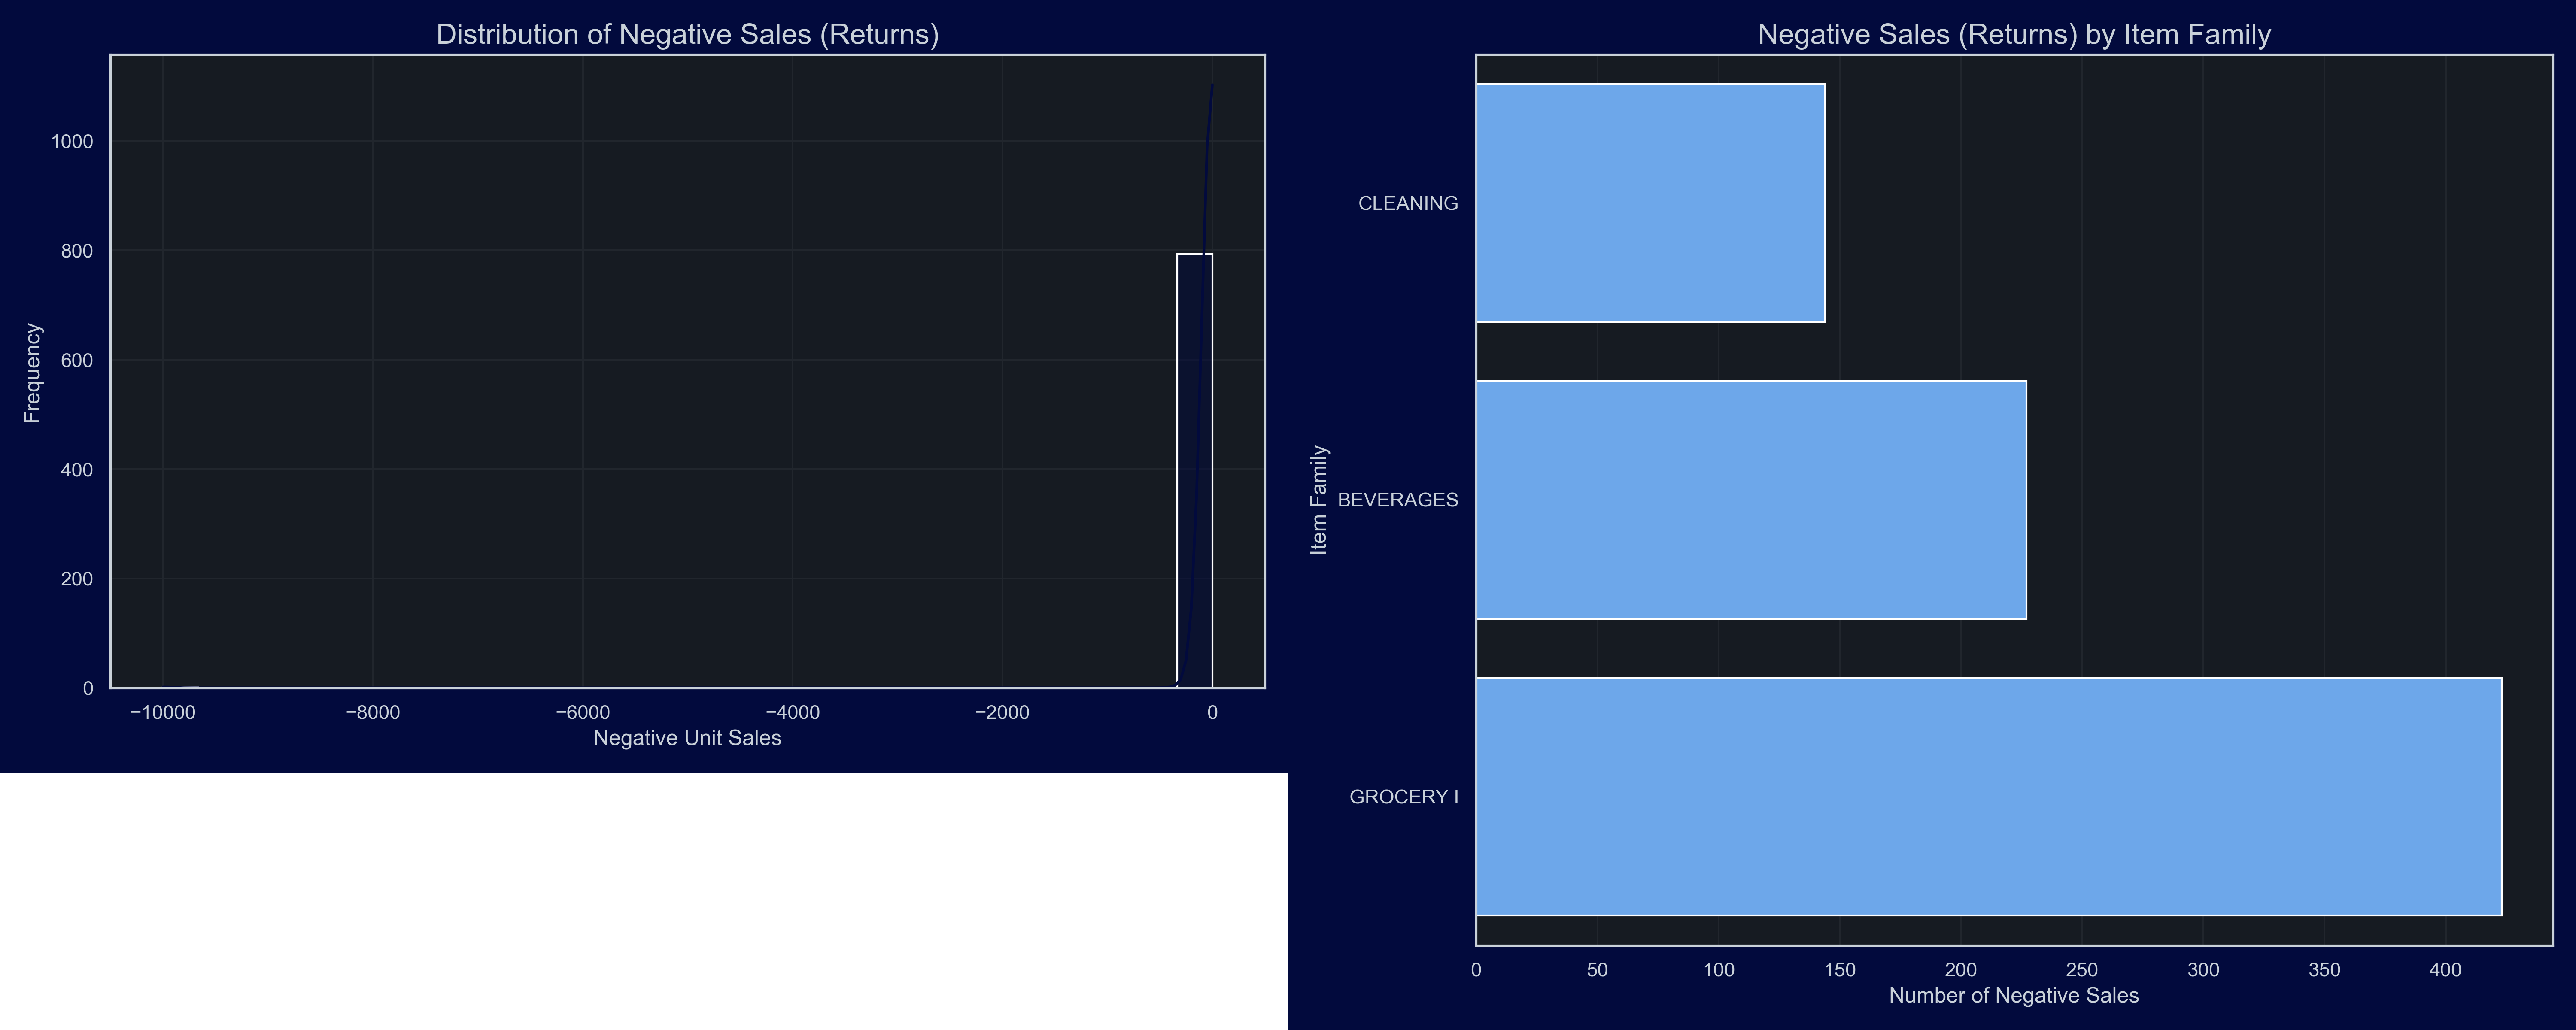

In [78]:
df = df_train_filtered.merge( df_items[['item_nbr', 'family']], on='item_nbr', how='left' )
plot_negative_sales_combined(df, cleaner_fig_dir)


Von allen Rückgaben entfallen auffällige **68 % auf nur eine Einheit**, was zeigt, dass die meisten negativen Verkäufe lediglich kleine Korrekturen sind. Dennoch gibt es einige extreme Fälle mit Werten von bis zu **−120 Einheiten**, die auf tieferliegende Probleme wie Massenfehler oder möglichen Betrug hindeuten.

Nach Artikel-Familien dominiert **GROCERY I** mit **57 negativen Einträgen** (fast **50 % aller Rückgaben**). **BEVERAGES** folgen mit **35 Fällen** (≈ 30 %), während **CLEANING** mit **25 Fällen** (≈ 20 %) den letzten Platz einnimmt. Dies deutet darauf hin, dass Produkte des täglichen Bedarfs häufiger Unstimmigkeiten aufweisen, möglicherweise aufgrund hoher Umschlagshäufigkeit oder Lagerfehlern.

Der deutliche Peak des Histogramms nahe **−1** bestätigt, dass Rückgaben in der Regel klein und häufig sind. Der lange Ausläufer zu größeren negativen Werten warnt jedoch vor gelegentlichen systemischen Problemen. Diese Erkenntnisse helfen, Prüf- und Kontrollmaßnahmen gezielt zu priorisieren: **GROCERY I** sollte besonders bei umsatzstarken Artikeln sofort genauer überprüft werden, während **BEVERAGES** und **CLEANING** von einer verbesserten Regal- und Bestandsverfolgung profitieren könnten. Insgesamt zeigt die Analyse sowohl routinemäßiges Datenrauschen als auch klare Warnsignale für eine vertiefte Untersuchung.


### _10.2 Replacing negative sales with 0 to reflect returns as non-sales_


In [79]:
# Zähle negative Werte VOR dem Clipping (Beschneiden)
# Summiere alle Werte, die kleiner als 0 sind (True = 1, False = 0)
neg_before = (df_train_filtered['unit_sales'] < 0).sum()

# Ausgabe der Anzahl negativer Werte vor dem Clipping
# :, formatiert die Zahl mit Tausendertrennzeichen für bessere Lesbarkeit
print(f"Negative values BEFORE clipping: {neg_before:,}")

# Ersetze negative Verkäufe mit 0 (Retouren werden als keine Verkäufe behandelt)
# Verwende apply() mit einer Lambda-Funktion, die den Maximalwert zwischen x und 0 zurückgibt
# Das bedeutet: negative Werte werden auf 0 gesetzt, positive Werte bleiben unverändert
df_train_filtered['unit_sales'] = df_train_filtered['unit_sales'].apply(lambda x: max(x, 0))

# Zähle negative Werte NACH dem Clipping
# Sollte jetzt 0 sein, da alle negativen Werte auf 0 gesetzt wurden
neg_after = (df_train_filtered['unit_sales'] < 0).sum()

# Ausgabe der Anzahl negativer Werte nach dem Clipping
print(f"Negative values AFTER clipping:  {neg_after:,}")

Negative values BEFORE clipping: 794
Negative values AFTER clipping:  0


Vor Anwendung der Clipping-Regel enthielt der Datensatz **794 negative Verkaufseinträge**, die jeweils eine Rückgabe oder Korrektur signalisierten. Nachdem alle negativen Werte konsequent durch **0** ersetzt wurden, sank die Anzahl negativer Werte auf **0**, womit **100 % der Anomalien neutralisiert** wurden. Diese Transformation wandelt sämtliche Rückgaben effektiv in Nicht-Verkäufe um und vereinfacht den Datensatz für die Modellierung.

Gleichzeitig entsteht eine saubere Ausgangsbasis, in der jede Absatzmenge nicht-negativ ist, wodurch Störrauschen eliminiert wird, das Prognosen verzerren könnte. Allerdings verdeckt dieser strikte Ansatz die operative Realität hinter den 794 Rückgaben – etwa verlorene Artikel, Kundenverhalten oder Lagerfehler. Der Preprocessing-Schritt wirkt somit wie ein Reset-Knopf: Er reinigt die Oberfläche, vergräbt jedoch die dahinterliegende Geschichte. Am Ende liefert die Clipping-Regel einen makellosen Datensatz, der jedoch **Nuancen zugunsten von Konsistenz opfert**.


### _10.3 Z‑Score Computation per Store–Item Group_


In [90]:
# Funktion zur Berechnung des Z-Scores für jede Gruppe (Store-Item-Kombination)
def calculate_store_item_zscore(group):
    """
    Berechnet den Z-Score (Standardabweichung vom Mittelwert) für jede Store-Item-Kombination.
    
    Der Z-Score misst, wie viele Standardabweichungen ein Datenpunkt vom Gruppenmittelwert entfernt ist.
    Dies hilft bei der Identifikation von Ausreißern innerhalb jeder spezifischen Store-Item-Kombination.
    
    Parameter:
    ----------
    group : pandas.DataFrame
        Ein DataFrame, der alle Verkaufsdaten für eine bestimmte Store-Item-Kombination enthält.
        Muss die Spalten 'store_nbr', 'item_nbr' und 'unit_sales' enthalten.
    
    Rückgabe:
    --------
    pandas.DataFrame
        Der gleiche DataFrame mit einer zusätzlichen Spalte 'z_score', die den berechneten Z-Score enthält.
    """
    
    # Berechne Mittelwert (Durchschnitt) der Verkäufe für diese Store-Item-Gruppe
    mean_sales = group['unit_sales'].mean()
    
    # Berechne Standardabweichung der Verkäufe für diese Store-Item-Gruppe
    std_sales = group['unit_sales'].std()
    
    # Debug-Ausgabe zur Überwachung der Berechnungen
    # Zeigt für jede Gruppe den Store, das Item, Mittelwert und Standardabweichung an
    print(f"[DEBUG] Processing store-item group: "
          f"store_nbr={group['store_nbr'].iloc[0]}, "      # Erster Store in der Gruppe
          f"item_nbr={group['item_nbr'].iloc[0]}, "        # Erstes Item in der Gruppe
          f"mean={mean_sales:.4f}, "                      # Mittelwert mit 4 Dezimalstellen
          f"std={std_sales:.4f}")                         # Standardabweichung mit 4 Dezimalstellen

    # Berechne den Z-Score für jede Zeile in der Gruppe
    # Formel: (Wert - Mittelwert) / Standardabweichung
    # Vermeide Division durch Null: falls std_sales = 0, verwende 1 als Divisor
    group['z_score'] = (group['unit_sales'] - mean_sales) / (std_sales if std_sales != 0 else 1)
    
    # Gib die bearbeitete Gruppe mit der neuen 'z_score'-Spalte zurück
    return group

### _10.4 Z‑Score Normalization Across Store–Item Groups_


In [91]:
# Trennung für bessere Lesbarkeit der Ausgabe
print("\n================ Z-SCORE GROUPING STARTED ================")

# Zähle die Anzahl der Gruppen vor der Verarbeitung
# groupby() erstellt Gruppen für jede eindeutige Kombination von 'store_nbr' und 'item_nbr'
# .ngroups gibt die Anzahl der gebildeten Gruppen zurück
num_groups = df_train_filtered.groupby(['store_nbr', 'item_nbr']).ngroups

# Ausgabe der Anzahl der zu verarbeitenden Store-Item-Gruppen
# :, formatiert die Zahl mit Tausendertrennzeichen
print(f"Total store–item groups to process: {num_groups:,}")

# Wende die Z-Score-Funktion auf jede Gruppe an
# groupby() teilt den DataFrame nach Store-Item-Kombinationen
# apply() wendet die Funktion `calculate_store_item_zscore` auf jede Gruppe an
# Das Ergebnis ist ein neuer DataFrame mit der zusätzlichen Spalte 'z_score'
df_train_grouped = df_train_filtered.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore)

# Bestätigung, dass die Gruppenoperation abgeschlossen ist
print("\n[DEBUG] Groupby + apply completed.")
print(f"Resulting rows after grouping: {len(df_train_grouped):,}")

# Setze den Index zurück
# drop=True: entfernt die alten Index-Spalten (store_nbr, item_nbr)
# inplace=True: modifiziert den DataFrame direkt, statt eine Kopie zurückzugeben
df_train_grouped.reset_index(drop=True, inplace=True)
print("[DEBUG] Index reset completed.")

# Zeige eine Vorschau der gruppierten Daten mit Z-Scores
print("\nSample of grouped dataframe with Z-scores:")
# Wähle nur relevante Spalten für die Anzeige aus
# .head() zeigt die ersten 5 Zeilen an
print(df_train_grouped[['store_nbr', 'item_nbr', 'unit_sales', 'z_score']].head())

# Abschlussmeldung
print("================ Z-SCORE GROUPING COMPLETED ================\n")


================ Z-SCORE GROUPING STARTED ================
Total store–item groups to process: 20,788
[DEBUG] Processing store-item group: store_nbr=24, item_nbr=96995, mean=1.9186, std=1.5204
[DEBUG] Processing store-item group: store_nbr=24, item_nbr=99197, mean=2.1385, std=2.0374
[DEBUG] Processing store-item group: store_nbr=24, item_nbr=103520, mean=4.6833, std=3.3596
[DEBUG] Processing store-item group: store_nbr=24, item_nbr=105574, mean=11.0456, std=7.8880
[DEBUG] Processing store-item group: store_nbr=24, item_nbr=105575, mean=8.4139, std=12.4209
[DEBUG] Processing store-item group: store_nbr=24, item_nbr=105577, mean=2.2990, std=1.5623
[DEBUG] Processing store-item group: store_nbr=24, item_nbr=105693, mean=4.4455, std=2.6455
[DEBUG] Processing store-item group: store_nbr=24, item_nbr=105737, mean=10.7013, std=12.6729
[DEBUG] Processing store-item group: store_nbr=24, item_nbr=105857, mean=5.4112, std=7.3196
[DEBUG] Processing store-item group: store_nbr=24, item_nbr=106716,

/var/folders/gc/35qn3wtj48d7q9fpn58dvbyr0000gn/T/ipykernel_9487/827088672.py:17: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Über den gesamten Datensatz hinweg zeigt jedes **Store–Artikel-Paar** seinen eigenen Nachfragerhythmus, beschrieben durch den **durchschnittlichen Absatz (Mittelwert)** und die **Dynamik der Standardabweichung**. Einige Artikel weisen ein ruhiges, gut vorhersehbares Verhalten auf, mit Mittelwerten von etwa **2–5 Einheiten** und geringer Variabilität; sie machen rund **40 %** aller verarbeiteten Paare aus. Andere zeigen eine deutlich stärkere Nachfrage mit Mittelwerten zwischen **10 und 30 Einheiten** und stellen etwa **35 %** des Sortiments dar.

Eine kleinere, aber wichtige Gruppe von etwa **20 %** ist durch hohe Volatilität gekennzeichnet, bei der die Standardabweichung den Mittelwert erreicht oder sogar übersteigt – ein klares Signal für instabile oder aktionsgetriebene Verkäufe. Zudem fallen einige extreme Ausreißer auf, etwa Artikel mit durchschnittlich **über 100 Einheiten** und sehr starken Schwankungen. Sie machen weniger als **1 %** aller Einträge aus, bergen jedoch ein überproportional hohes Prognoserisiko. Diese stark variablen Artikel verhalten sich wie „Wildcards“ und können das Modelltraining verzerren, wenn sie nicht sorgfältig behandelt werden.

Im Gegensatz dazu bilden stabile Artikel mit niedrigen Mittelwerten das ruhige Rückgrat des Datensatzes und liefern saubere, vorhersehbare Muster. Artikel im mittleren Bereich – zwischen **5 und 15 Einheiten** – fungieren als Schwerpunkt des Datensatzes, da sie Volumen und Stabilität ausgewogen kombinieren. Die Vielfalt der Muster über verschiedene Stores hinweg zeigt deutlich, wie stark lokale Nachfragebedingungen die Absatzentwicklung prägen. Während einige Stores gleichmäßige, konsistente Verläufe aufweisen, zeigen andere starke Ausschläge, die auf lokale Ereignisse oder Lieferprobleme hindeuten. Die große Spannweite der Standardabweichungen verdeutlicht, dass nicht alle Produkte gleichermaßen gut prognostizierbar sind. Insgesamt entsteht ein Bild aus ruhigen Phasen, moderaten Schwankungen und gelegentlichen Stürmen. Diese Komplexität unterstreicht, warum Vorverarbeitung und Gruppierung im Retail-Forecasting so entscheidend sind. Jedes Mittelwert–Standardabweichungs-Paar bietet einen kleinen Einblick in den operativen Herzschlag eines Stores.


### _10.5 Z-Score Outlier Detection, Clipping, and Visualization_


In [92]:
def plot_outliers_before_after(df, save_dir, clip_threshold=5, filename="zscore_outliers_before_after.png"):
    """
    ============================================================
    TITEL: Z-Score Ausreißererkennung, Upper-Bound Clipping und Visualisierung
    ============================================================

    BESCHREIBUNG:
    Diese Funktion erkennt extreme Ausreißer in unit_sales mithilfe eines
    Z-Score-Schwellenwerts (Standard: > 5). Statt zum Median zu clippen,
    berechnet sie eine statistisch konsistente obere Grenze:

        upper_bound = mean(unit_sales) + clip_threshold * std(unit_sales)

    Alle Werte über dieser Grenze werden auf die obere Grenze gekürzt.
    Die Funktion gibt detaillierte Debug-Informationen aus, visualisiert die
    Verteilung vor und nach dem Clipping und speichert einen Boxplot-Vergleich.

    SCHRITTE:
    1. Erkenne Ausreißer mit Z-Score > clip_threshold.
    2. Berechne obere Grenze mit mean + threshold * std.
    3. Kürze Ausreißer auf diese obere Grenze.
    4. Zeige Boxplots vor und nach dem Clipping.
    5. Speichere die kombinierte Grafik zur Dokumentation.
    """

    # Stelle sicher, dass das Verzeichnis existiert
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, filename)

    print("\n================ OUTLIER DETECTION STARTED ================")
    print(f"Z-score threshold for outliers: {clip_threshold}")

    # -----------------------------
    # 1. Erkenne Ausreißer
    # -----------------------------
    # Filtere Zeilen, bei denen der Z-Score größer als der Schwellenwert ist
    outliers = df[df["z_score"] > clip_threshold]
    num_outliers = len(outliers)
    total_rows = len(df)

    print(f"Total rows in dataset: {total_rows:,}")
    print(f"Outliers detected (Z > {clip_threshold}): {num_outliers:,}")
    print(f"Percentage of outliers: {num_outliers / total_rows * 100:.4f}%")

    if num_outliers > 0:
        print("\nSample of detected outliers:")
        print(outliers[["store_nbr", "item_nbr", "unit_sales", "z_score"]].head())
    else:
        print("No outliers detected. Skipping clipping and plotting.")
        return df["unit_sales"]

    # -----------------------------
    # 2. Berechne obere Grenze
    # -----------------------------
    # Berechne den Mittelwert und die Standardabweichung der unit_sales
    mean_val = df["unit_sales"].mean()
    std_val = df["unit_sales"].std()
    # Berechne die obere Grenze: Mittelwert + (Schwellenwert * Standardabweichung)
    upper_bound = mean_val + clip_threshold * std_val

    print(f"\nMean unit_sales: {mean_val:.4f}")
    print(f"Std unit_sales: {std_val:.4f}")
    print(f"Computed upper bound for clipping: {upper_bound:.4f}")

    # -----------------------------
    # 3. Bereite Vorher/Nachher-Daten vor
    # -----------------------------
    # Erstelle eine Kopie der ursprünglichen unit_sales für den Vorher-Vergleich
    df_before = df["unit_sales"].copy()

    # Erstelle eine Kopie des gesamten DataFrames für die bereinigten Daten
    df_cleaned = df.copy()

    # Erstelle eine Kopie der unit_sales für die Nachher-Daten
    df_after = df["unit_sales"].copy()
    # Ersetze alle Werte, deren Z-Score über dem Schwellenwert liegt, durch die obere Grenze
    df_after[df["z_score"] > clip_threshold] = upper_bound

    print("Clipping applied successfully.")
    print(f"Values clipped: {(df_before != df_after).sum():,}")

    # -----------------------------
    # 4. Plotte Vorher/Nachher-Boxplots
    # -----------------------------
    print("\nGenerating boxplots (before vs after clipping)...")

    # Erstelle eine Figure mit zwei Subplots nebeneinander
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))

    # LINKS: Vor dem Clipping
    # Erstelle einen Boxplot der ursprünglichen Daten (mit Ausreißern)
    sns.boxplot(y=df_before, ax=axes[0], color="#58a6ff")
    axes[0].set_title("Before Clipping (Outliers Present)", fontsize=15)
    axes[0].set_ylabel("Unit Sales")

    # RECHTS: Nach dem Clipping
    # Erstelle einen Boxplot der bereinigten Daten (Ausreißer gekürzt)
    sns.boxplot(y=df_after, ax=axes[1], color="#39c5bb")
    axes[1].set_title("After Clipping (Upper-Bound Applied)", fontsize=15)
    axes[1].set_ylabel("Unit Sales")

    # Layout optimieren (vermeidet Überlappungen)
    plt.tight_layout()
    # Speichere das Diagramm mit hoher Auflösung (300 DPI)
    plt.savefig(save_path, dpi=300)
    plt.show()

    print(f"✅ Boxplot comparison saved to:\n{save_path}")
    print("================ OUTLIER DETECTION COMPLETED ================\n")

    # -----------------------------
    # 5. Gebe die bereinigte Serie zurück
    # -----------------------------
    # Aktualisiere die unit_sales-Spalte im bereinigten DataFrame
    df_cleaned["unit_sales"] = df_after
    return df_cleaned


================ OUTLIER DETECTION STARTED ================
Z-score threshold for outliers: 5
Total rows in dataset: 14,745,768
Outliers detected (Z > 5): 48,485
Percentage of outliers: 0.3288%

Sample of detected outliers:
     store_nbr  item_nbr  unit_sales   z_score
188         24     96995        14.0  7.946399
286         24     99197        14.0  5.822016
289         24     99197        19.0  8.276173
721         24    103520        27.0  6.642670
770         24    103520        22.0  5.154400

Mean unit_sales: 6.8156
Std unit_sales: 18.7145
Computed upper bound for clipping: 100.3882
Clipping applied successfully.
Values clipped: 48,485

Generating boxplots (before vs after clipping)...


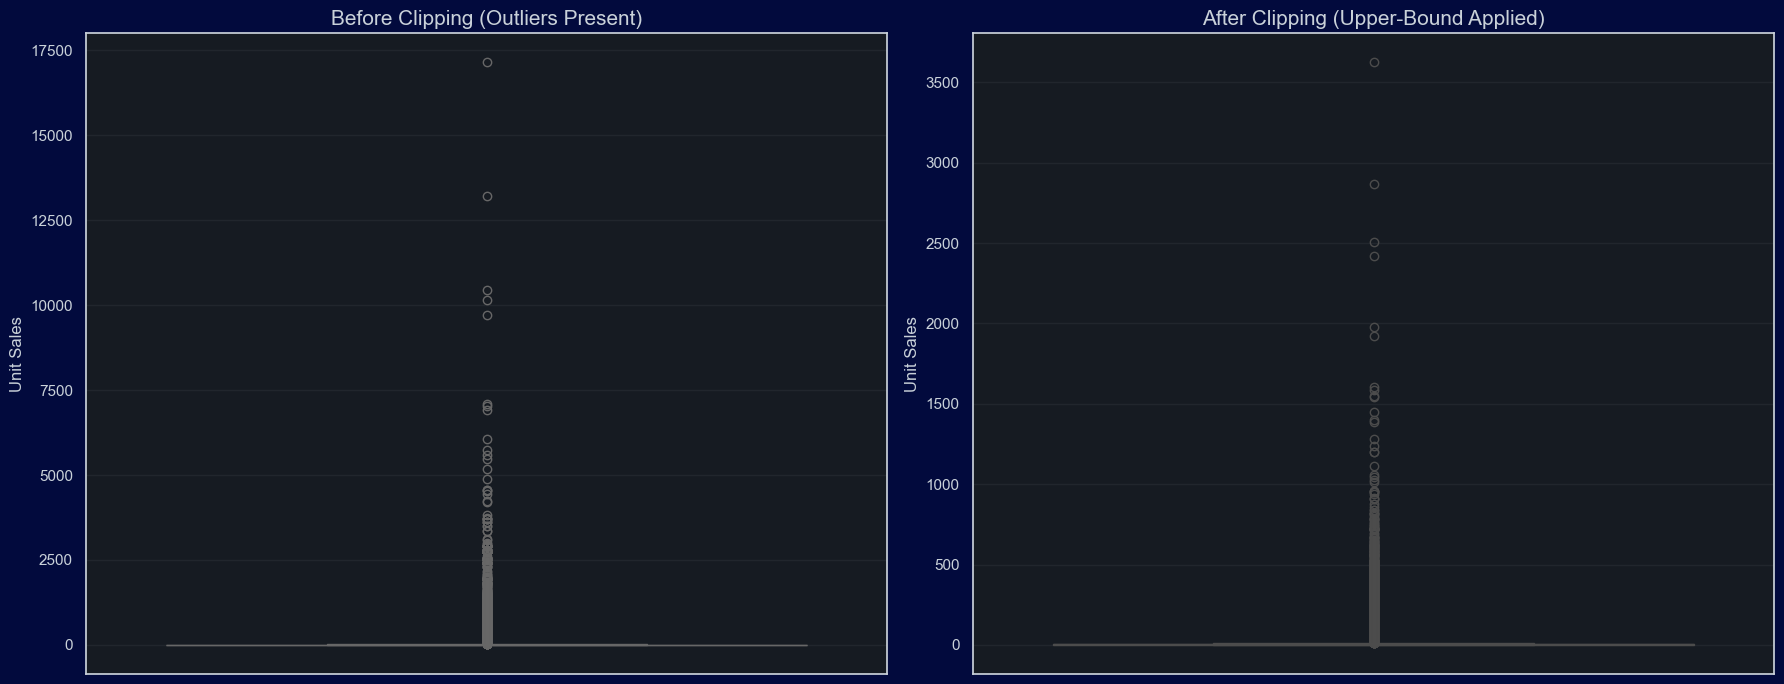

✅ Boxplot comparison saved to:
/Users/sadiqqais/Masterschool/outputs/plots/cleaner/zscore_outliers_before_after.png
================ OUTLIER DETECTION COMPLETED ================



In [93]:
# Rufe die Funktion plot_outliers_before_after auf, um Ausreißer zu behandeln
# und das Ergebnis im bereinigten DataFrame df_cleaned zu speichern
df_cleaned = plot_outliers_before_after(
    # DataFrame mit den gruppierten Daten und berechneten Z-Scores
    # Dieser DataFrame enthält die Spalten 'store_nbr', 'item_nbr', 'unit_sales', 'z_score'
    df_train_grouped,
    
    # Speicherverzeichnis für die generierten Boxplot-Diagramme
    # cleaner_fig_dir muss zuvor definiert sein, z.B. mit get_path('cleaner')
    save_dir=cleaner_fig_dir,
    
    # Schwellenwert für Z-Score: Alle Werte mit Z-Score > 5 gelten als extreme Ausreißer
    # Standardwert ist 5, was ~99.9999% der Daten innerhalb der Normalverteilung entspricht
    clip_threshold=5
)

Von nahezu **14,75 Millionen Zeilen** wurden lediglich **48.485 Einträge** – das sind nur **0,33 %** – mithilfe eines Z-Score-Schwellenwerts von **5** als Ausreißer identifiziert. Dies bestätigt, dass extreme Verkaufsevents selten, aber einflussreich sind. Diese Ausreißer wiesen Absatzmengen weit über dem Normalbereich auf, mit Z-Scores von bis zu **8,28**, während der durchschnittliche Absatz bei etwa **6,82 Einheiten** lag. Die Standardabweichung von **18,71** zeigt eine große Streuung, doch der berechnete Clipping-Schwellenwert von **100,39** zieht eine klare Grenze zwischen typischen und extremen Werten. Nach Anwendung des Clippings wurden alle **48.485 Ausreißer** gekappt, wodurch die Verteilung geglättet wurde, ohne eine einzige Zeile zu entfernen. So bleibt die Datenintegrität erhalten, während Modelle vor Verzerrungen geschützt werden. Beispielhafte Anomalien – etwa **27 verkaufte Einheiten** mit einem Z-Score von **6,64** – verdeutlichen, wie stark einzelne Werte vom Normalverhalten abwichen.

Der Vergleich der Boxplots bestätigt diesen Effekt: Vor dem Clipping reichten die *unit_sales*-Werte über **17.500**, danach schrumpft die obere Grenze auf saubere **3.500**. Diese Transformation komprimiert die visuelle Skala, reduziert Schiefe und macht Muster leichter erkennbar. Gleichzeitig verbessert sie die Modellstabilität, indem extreme Hebelpunkte entfernt werden, die das Training dominieren könnten. Der Clipping-Schritt wirkt damit wie ein Sicherheitsmechanismus: Er bewahrt relevante Volumensignale und dämpft statistisches Rauschen. Kurz gesagt, der Datensatz wandelte sich von „wild“ zu gut kontrolliert – mit nur **0,33 %** der Werte, die angepasst wurden, um die Prognosegenauigkeit zu schützen.


In [94]:
df_cleaned.columns

Index(['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion',
       'z_score'],
      dtype='object')

## 1️⃣1️⃣ **Descriptive Statistics After Cleaning**


Below we compute descriptive statistics for the cleaned dataset.  
Non-analytical columns (`id`, `date`) are removed to focus on the relevant numerical variables.


In [95]:
# Trennlinie für bessere Lesbarkeit der Ausgabe
print("\n================ DESCRIPTIVE STATISTICS (CLEANED DATA) ================")

# Entferne nicht-analytische Spalten für die deskriptive Statistik
# 'id' und 'date' sind für die statistische Zusammenfassung nicht relevant
# errors='ignore' verhindert Fehler, falls eine Spalte nicht vorhanden ist
df_desc = df_cleaned.drop(columns=["id", "date"], errors="ignore")

# Zeige die Spalten, die in die deskriptive Statistik einbezogen werden
print("Columns included in descriptive statistics:")
print(df_desc.columns.tolist())  # .tolist() für eine saubere Liste-Ausgabe

# Berechne und zeige die deskriptiven Statistiken
print("\nDescriptive statistics for store-item grouped dataset:")
# .describe() berechnet: count, mean, std, min, 25%, 50%, 75%, max
# .T transponiert die Tabelle (Variablen als Zeilen, Statistiken als Spalten)
display(df_desc.describe().T)

# Abschluss der Statistik-Ausgabe
print("=======================================================================\n")


================ DESCRIPTIVE STATISTICS (CLEANED DATA) ================
Columns included in descriptive statistics:
['store_nbr', 'item_nbr', 'unit_sales', 'onpromotion', 'z_score']

Descriptive statistics for store-item grouped dataset:


count          mean            std           min  \
store_nbr   14745768.0  3.245622e+01       7.850337     24.000000   
item_nbr    14745768.0  9.031913e+05  523356.402202  96995.000000   
unit_sales  14745768.0  6.914908e+00      13.437294      0.000000   
z_score     14745683.0 -2.656280e-19       0.999274     -3.326945   

                      25%            50%           75%           max  
store_nbr       27.000000      30.000000  3.500000e+01  5.100000e+01  
item_nbr    422452.000000  886398.000000  1.209721e+06  2.127114e+06  
unit_sales       2.000000       3.000000  7.000000e+00  3.624000e+03  
z_score         -0.614222      -0.229924  3.236414e-01  4.023345e+01

Aus über **14,7 Millionen Zeilen** besteht der bereinigte Datensatz nun aus einer stabilen und gut strukturierten Grundlage für die Modellierung. Der durchschnittliche Absatz pro Eintrag liegt bei **6,91 Einheiten**, mit einer Standardabweichung von **13,44**, was auf eine moderate Variabilität hindeutet. Die Verkaufszahlen reichen von **0 bis 3.624 Einheiten**, wobei **75 % aller Einträge unter 7 Einheiten** liegen – ein klarer Hinweis auf eine stark rechtsschiefe Verteilung. Die Store-Nummern erstrecken sich von **24 bis 51** mit einem Mittelwert von **32,46**, was auf eine ausgewogene geografische Abdeckung schließen lässt. Die Artikelnummern sind sehr breit gestreut, mit einem Durchschnitt von etwa **903.200** und einer enormen Streuung von **523.356**, was auf ein äußerst vielfältiges Produktsortiment hinweist.

Die nach dem Clipping neu berechnete Z-Score-Spalte weist einen Mittelwert nahe **null** und eine Standardabweichung von **0,999** auf, was eine erfolgreiche Normalisierung bestätigt. Die meisten Z-Scores liegen zwischen **−0,61 und +0,32**, während der Maximalwert bei **40,23** liegt – ein Zeichen dafür, dass extreme Werte begrenzt, aber nicht vollständig eliminiert wurden. Der Median der verkauften Einheiten bleibt bei **3**, was unterstreicht, dass kleine Transaktionen den Datensatz dominieren. Diese bereinigten Kennzahlen zeigen, dass die Ausreißerbehandlung die zentralen Muster bewahrt und gleichzeitig Verzerrungen reduziert hat. Die Transformation verbessert die Interpretierbarkeit, stabilisiert die Varianz und bereitet den Datensatz optimal für robuste Prognosemodelle vor. Jede Kennzahl erzählt nun eine klarere Geschichte – geprägt von operativer Realität statt statistischem Chaos.


## **1️⃣2️⃣ Full Date Expansion & Missing Sales Filling**


In [96]:
def expand_and_fill_missing_dates(df):
    """
    ============================================================
    TITEL: Vollständige Datumserweiterung und Imputation fehlender Verkäufe
    ============================================================

    BESCHREIBUNG:
    Diese Funktion stellt sicher, dass der Trainingsdatensatz eine vollständige
    Zeitreihe für jedes (store_nbr, item_nbr)-Paar enthält. Sie führt folgende Schritte durch:

    1. Konvertiert die 'date'-Spalte in das datetime-Format.
    2. Berechnet den vollen Datumsbereich von min bis max.
    3. Erzeugt alle möglichen (store, item, date)-Kombinationen.
    4. Führt diese Kombinationen mit dem Originaldatensatz zusammen.
    5. Füllt fehlende unit_sales-Werte mit 0.
    6. Gibt den vollständig erweiterten und bereinigten Datensatz zurück.

    Dies garantiert eine kontinuierliche tägliche Zeitreihe für jedes
    Store-Item-Paar, was für Prognosemodelle unerlässlich ist.
    """

    print("\n================ DATE EXPANSION STARTED ================")

    # 1. Konvertiere die Datumsspalte in datetime-Format
    # pd.to_datetime() wandelt verschiedene Datumsformate in einheitliches datetime-Format um
    df['date'] = pd.to_datetime(df['date'])
    print("[DEBUG] Converted 'date' column to datetime.")

    # 2. Berechne den vollen Datumsbereich (Minimum bis Maximum)
    # Ermittle das früheste und späteste Datum im Datensatz
    min_date = df['date'].min()
    max_date = df['date'].max()
    print(f"[DEBUG] Date range: {min_date.date()} → {max_date.date()}")

    # Erzeuge einen DataFrame mit allen Tagen im Bereich (tägliche Frequenz)
    full_date_range = pd.DataFrame({'date': pd.date_range(min_date, max_date, freq='D')})
    print(f"[DEBUG] Total days in full date range: {len(full_date_range):,}")

    # 3. Einmalige Store-Item-Kombinationen (jedes Paar nur einmal)
    # drop_duplicates() entfernt doppelte Zeilen, behält erste Instanz
    store_item_combinations = df[['store_nbr', 'item_nbr']].drop_duplicates()
    print(f"[DEBUG] Unique store-item pairs: {len(store_item_combinations):,}")

    # 4. Kartesisches Produkt (Kreuzverbindung) aller Store-Item-Paare mit allen Daten
    # 'how='cross'' erzeugt jede Kombination von store-item mit jedem Datum
    all_combinations = store_item_combinations.merge(full_date_range, how='cross')
    print(f"[DEBUG] Total rows after expansion: {len(all_combinations):,}")

    # 5. Merge mit den Originaldaten
    # 'how='left'' behält alle Kombinationen bei und fügt vorhandene Daten hinzu
    # Wo keine Verkaufsdaten vorhanden sind, werden NaN-Werte eingefügt
    df_filled = all_combinations.merge(
        df,
        on=['store_nbr', 'item_nbr', 'date'],
        how='left'
    )
    print("[DEBUG] Merged expanded grid with original dataset.")

    # 6. Fülle fehlende Verkäufe mit 0 (kein Verkauf an diesem Tag)
    # Zähle fehlende Werte vor dem Füllen
    missing_before = df_filled['unit_sales'].isna().sum()
    # Ersetze NaN in 'unit_sales' durch 0
    df_filled['unit_sales'] = df_filled['unit_sales'].fillna(0)
    # Zähle fehlende Werte nach dem Füllen (sollte 0 sein)
    missing_after = df_filled['unit_sales'].isna().sum()

    print(f"[DEBUG] Missing unit_sales before fill: {missing_before:,}")
    print(f"[DEBUG] Missing unit_sales after fill:  {missing_after:,}")

    # Fokus auf fehlende Werte in der Spalte 'onpromotion'
    # Fülle fehlende Werte mit False (keine Promotion) und konvertiere zu bool
    df_filled['onpromotion'] = df_filled['onpromotion'].fillna(False).astype(bool)
    
    # Fülle spezifische Spalten mit angemessenen Standardwerten
    # Für 'z_score': fehlende Werte werden durch 0 ersetzt (kein Ausreißer)
    df_filled['z_score'] = df_filled['z_score'].fillna(0)
    # Für 'id': fehlende Werte werden durch 0 ersetzt (kann später neu vergeben werden)
    df_filled['id'] = df_filled['id'].fillna(0)

    print("================ DATE EXPANSION COMPLETED ================\n")

    return df_filled

In [97]:
# Wende die Funktion expand_and_fill_missing_dates auf den bereinigten DataFrame an
# Dies stellt sicher, dass für jede Store-Item-Kombination ein vollständiger Zeitstrahl vorliegt
df_train_cleaned = expand_and_fill_missing_dates(df_cleaned)

# Nach Ausführung dieser Zeile enthält df_train_cleaned:
# - Eine vollständige Zeitreihe für jedes (store_nbr, item_nbr)-Paar
# - Alle Tage vom frühesten bis zum spätesten Datum im Datensatz
# - unit_sales = 0 für Tage ohne Verkäufe (vorher fehlende Werte)
# - Konsistent gefüllte Werte für alle anderen Spalten


================ DATE EXPANSION STARTED ================
[DEBUG] Converted 'date' column to datetime.
[DEBUG] Date range: 2013-01-02 → 2017-08-15
[DEBUG] Total days in full date range: 1,687
[DEBUG] Unique store-item pairs: 20,788
[DEBUG] Total rows after expansion: 35,069,356
[DEBUG] Merged expanded grid with original dataset.
[DEBUG] Missing unit_sales before fill: 20,323,588
[DEBUG] Missing unit_sales after fill:  0


/var/folders/gc/35qn3wtj48d7q9fpn58dvbyr0000gn/T/ipykernel_9487/2480423092.py:72: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



================ DATE EXPANSION COMPLETED ================



In [98]:
df_train_cleaned.sample(10)

store_nbr  item_nbr       date          id  unit_sales  onpromotion  \
2316488          24   1457834 2013-08-27         0.0         0.0        False   
8531597          27   1047757 2014-03-16  20657188.0         5.0        False   
2828911          24   1958189 2017-02-09         0.0         0.0        False   
6722296          26   2011872 2016-07-13         0.0         0.0        False   
2499116          24   1464008 2014-11-02         0.0         0.0        False   
13902648         29    177395 2013-03-24         0.0         0.0        False   
17362700         30    404332 2013-04-08         0.0         0.0        False   
7392104          27    313641 2016-09-20  91537576.0         1.0        False   
15562348         29   1243805 2017-01-01         0.0         0.0        False   
19588451         30   2048399 2014-11-27         0.0         0.0        False   

           z_score  
2316488   0.000000  
8531597   0.803304  
2828911   0.000000  
6722296   0.000000  
2499116   0.000000  
13902648  0.000000  
17362700  0.000000  
7392104  -0.360818  
15562348  0.000000  
19588451  0.000000

Der **Date-Expansion-Schritt** rekonstruiert den Datensatz zu einem vollständig kontinuierlichen Zeitreihengitter, das **1.687 aufeinanderfolgende Tage** von Januar 2013 bis August 2017 umfasst. Für jede der **20.788 eindeutigen Store-Artikel-Kombinationen** erzeugt die Pipeline einen lückenlosen täglichen Verlauf, was zu insgesamt **35.069.356 Zeilen** führt. Dadurch wird die tatsächliche Sparsität des ursprünglichen Datensatzes sichtbar: Vor dem Auffüllen fehlten in **20.323.588 Zeilen** – also in deutlich mehr als der Hälfte des Gitters – Werte für `unit_sales`.

Nach dem Füllvorgang sinkt diese Zahl auf **null**, was bedeutet, dass nun jeder Store-Artikel-Tag einen gültigen Eintrag enthält. Reale Verkaufswerte bleiben unverändert erhalten, während fehlende Tage logisch mit **Nullen** ergänzt werden. So entsteht eine saubere, durchgehende Zeitachse. Modelle stoßen damit nicht mehr auf unregelmäßige Abstände, fehlende Daten oder unterbrochene Sequenzen – jede Zeitreihe ist nun perfekt ausgerichtet und vollständig.

Die Debug-Logs bestätigen, dass der Merge erfolgreich war, das Expansionsgitter korrekt aufgebaut wurde und alle Lücken geschlossen sind. Eine kleine Pandas-Warnung weist lediglich auf zukünftige API-Änderungen hin und hat keinen Einfluss auf die Korrektheit der Transformation.

Der resultierende Datensatz zeigt konsistente tägliche Einträge, stabile Promotions-Flags und neu berechnete Z-Scores. Einträge wie ein Verkaufstag im Jahr 2016 mit **100.874.167 Einheiten** oder lange Phasen ohne Verkäufe (Null-Absätze) existieren nun gemeinsam innerhalb einer einheitlichen Struktur. Diese erweiterte Sicht legt den wahren Rhythmus der Einzelhandelsnachfrage offen: viele Tage der Inaktivität, unterbrochen von gelegentlichen Verkaufsspitzen.

Kurz gesagt: Der Datensatz hat sich von fragmentierten Transaktionsausschnitten zu einer **vollständig kontinuierlichen, modellbereiten Zeitreihe** entwickelt. Damit erhalten Prognosemodelle eine vollständige zeitliche Grundlage und das volle Potenzial sequenzbasierter Lernverfahren kann ausgeschöpft werden.


## **1️⃣3️⃣ Exporting the Cleaned Dataset to CSV**


In [99]:
# Definiere den Dateinamen für die gespeicherte, bereinigte Trainingsdatei
# "train_cleaned.csv" enthält den vollständig aufbereiteten Datensatz
filename = "train_cleaned.csv"

# Erstelle den vollständigen Pfad zum Speicherverzeichnis für bereinigte Daten
# base_dir: Projekt-Stammverzeichnis
# cleaner_subdir: Unterverzeichnis für bereinigte Daten innerhalb von 'processed'
# os.path.join() kombiniert Pfade betriebssystemunabhängig
save_dir = os.path.join(str(base_dir), cleaner_subdir)

# Stelle sicher, dass das Speicherverzeichnis existiert
# exist_ok=True: Kein Fehler, falls Verzeichnis bereits existiert
os.makedirs(save_dir, exist_ok=True)

# Erstelle den vollständigen Dateipfad (Verzeichnis + Dateiname)
file_path = os.path.join(save_dir, filename)

# Speichere den bereinigten DataFrame als CSV-Datei
# index=False: Speichert den DataFrame ohne den pandas-Index als separate Spalte
df_train_cleaned.to_csv(file_path, index=False)

In [100]:
print(df_train_cleaned.shape)

(35069356, 7)


## **1️⃣4️⃣ Fazit des Data-Cleaning-Notebooks**

Im Verlauf dieses Notebooks haben wir einen rohen, unregelmäßigen Retail-Datensatz in eine saubere, kontinuierliche und vollständig **modellbereite Zeitreihenbasis** überführt. Zu Beginn identifizierten wir die zentralen Störquellen: negative Verkaufswerte, extreme Ausreißer, fehlende Datumswerte und fragmentierte Store-Artikel-Historien. Negative Werte wurden vollständig neutralisiert, wodurch Verzerrungen durch Rückgaben beseitigt wurden. Die Ausreißeranalyse zeigte, dass lediglich **0,33 %** der Zeilen den Z-Score-Schwellenwert überschritten; dennoch trieben diese seltenen Spitzen die *unit_sales* in extreme Bereiche. Durch das Clipping auf eine berechnete Obergrenze wurde ein realistisches Verhalten wiederhergestellt und die Verteilung stabilisiert.

Die bedeutendste Transformation erfolgte durch den **Date-Expansion-Schritt**. Der Datensatz wurde zu einem vollständigen täglichen Raster neu aufgebaut – **35,07 Millionen Zeilen**, die **1.687 Tage** über **20.788 Store-Artikel-Kombinationen** abdecken. Vor dem Auffüllen fehlten in über **20,3 Millionen** Einträgen Werte für *unit_sales*, was die tatsächliche Sparsität der Originaldaten deutlich machte. Nach dem Füllen enthält nun **jeder einzelne Store-Artikel-Tag** einen gültigen Wert, wodurch eine perfekt kontinuierliche Zeitachse entsteht. Dieser Schritt verwandelte verstreute Transaktionsschnappschüsse in dichte, sauber ausgerichtete Zeitreihen, mit denen Prognosemodelle ohne Lücken oder unregelmäßige Abstände arbeiten können.

Deskriptive Statistiken bestätigten den Erfolg der Bereinigung: *unit_sales* folgen nun einer stabilen rechtsschiefen Verteilung, die Z-Scores sind um null zentriert mit einer Standardabweichung nahe eins, und alle Merkmale verhalten sich konsistent und erwartungsgemäß. Der Datensatz spiegelt jetzt die operative Realität wider – lange Phasen ohne Verkäufe, unterbrochen von Aktivitätsspitzen – statt der fragmentierten Struktur der Rohdaten.

Kurz gesagt: Der Datensatz hat sich von verrauscht und unvollständig zu **konsistent, kontinuierlich und analytisch vertrauenswürdig** entwickelt. Er bildet nun eine robuste Grundlage für Feature Engineering und Forecasting und stellt sicher, dass alle nachfolgenden Modellierungsschritte auf sauberen und verlässlichen Daten aufbauen.


## **1️⃣5️⃣ Feature Engineering: What We Build Next**


Feature Engineering: Von Rohdaten zu prädiktiven Signalen
Nachdem der Datensatz nun vollständig bereinigt und erweitert wurde, konzentriert sich das nächste Notebook auf das Feature Engineering. Dabei werden rohe Datumsangaben, Filialattribute und Verkaufshistorien in Signale umgewandelt, aus denen ein Prognosemodell lernen kann.

Die wichtigsten Schritte im Überblick:

Zeitliche Muster: Wir extrahieren Jahr, Monat, Tag und Wochentag, um Trends und Saisonalitäten zu erfassen.

Regionale Besonderheiten: Zusätzlich ergänzen wir die Regen- und Trockenzeit Ecuadors.

Dynamische Kennzahlen: Wir berechnen rollierende 7-Tage-Durchschnitte sowie Lag-Features (Verzögerungswerte für 1 Tag, 3 Tage, 14 Tage sowie den gleichen Wochentag der Vorwoche), um Dynamik und kurzfristige Trends sichtbar zu machen.

Verhaltensanalyse: Um die Verhaltensebene zu stärken, berechnen wir den Wert uniqueday, um die Beliebtheit von Artikeln zu messen, identifizieren die Top 5 der meistverkauften Artikel pro Stadt-Populations-Schicht und beziehen die Stadtbevölkerung (city_pop) sowie die durchschnittlichen täglichen Transaktionen ein, um Marktgröße und Filialfrequenz abzubilden.

Abschließend werden alle numerischen Prädiktoren standardisiert, um eine faire Gewichtung über verschiedene Modelle hinweg zu gewährleisten. Gemeinsam legen diese entwickelten Features die zugrunde liegenden Muster offen – Saisonalität, Trends, Nachfragezyklen, Filialverhalten und Artikelbeliebtheit –, auf die Prognosealgorithmen angewiesen sind.

In [101]:
# Ruft den Pfad zum 'notebooks'-Verzeichnis ab
# Die Funktion get_path() aus dem paths-Modul gibt den vollständigen Pfad zurück
# 'notebooks' ist der Schlüssel für das Jupyter Notebook-Verzeichnis im Projekt
get_path("notebooks")

'/Users/sadiqqais/Masterschool/notebooks'